# Summary of Nuvemshop Test

## Exploratory Data Analysis (EDA)

* The target variable, `Monthly Sales`, exhibits a wide range of values, spanning approximately 2 to 7 orders of magnitude.  
* Most features are numerical, with the exception of IDs.  
* The distribution of the target variable is **right-skewed**, with the presence of outliers. These outliers warrant further investigation, as they may represent unique or interesting segments. However, after detecting outliers using the IQR method, we concluded that they do not constitute distinct segments on their own. This conclusion arises from the fact that the distribution of other features does not significantly differ from a statistical perspective.  
* Correlation analysis highlighted several **prominent features** in relation to the target variable. We utilized Spearman's correlation, as it generalizes well to non-linear and monotonic relationships. This analysis revealed key associations with the target variable, including:
  * **Positive monotonic relationships** between `Followers`, `Estimated Sales - Domain`, `Estimated Page Views`, `Organic Traffic`, and `Monthly Sales`.  
  * **Negative monotonic relationships** between `Rank - Domain` and `Monthly Sales`.  

* The primary insight derived from the correlation analysis is that engagement metrics play a crucial role in identifying profitable companies. The data demonstrates that companies with a higher number of Instagram `Followers` tend to achieve higher `Monthly Sales`. Similarly, companies with substantial `Organic Traffic` are more likely to experience elevated `Monthly Sales`.  

* Additionally, the analysis revealed that the most profitable companies—those with the highest `Monthly Sales`—not necessarily tend to rank highly in Google search results. This observation aligns with the fact that Google's ranking mechanism is based on external factors, which may indirectly reflect a company's market performance.

* The Elbow method identified that companies can be grouped into two distinct segments based on `Monthly Sales`. This segmentation also highlighted clear differences across other variables, particularly the prominent ones outlined earlier.

## Data Modeling

- This study focuses on analyzing and modeling company sales data through a two-step approach: segmentation and regression. In the first step, clustering techniques were applied to segment companies based on their monthly sales. Subsequently, a classification algorithm was developed to assign companies to their respective segments. While the model effectively classified one segment, it faced challenges with the other due to data imbalance, necessitating potential strategies like resampling or adjusting class weights. In the second step, a regression model was built to predict monthly sales. Although the model performed well on a logarithmic scale, it exhibited limitations when evaluated on the original scale, suggesting opportunities for refinement through additional explanatory variables. The study highlights the alignment between exploratory data analysis (EDA) and model outcomes, emphasizing areas for improvement to enhance predictive precision. 

  - **Segmentation and Classification**

      After clustering the Monthly Sales variable, we implemented a classification algorithm to determine which segment a company belongs to. The model showed strong performance in classifying Segment 0 but struggled with Segment 1 (highly profitable companies), likely due to data imbalance. To address this, strategies such as resampling (oversampling or undersampling) or adjusting class weights during training could improve overall performance, particularly by enhancing Recall for Segment 1. Notably, the features identified as significant during the EDA were also highlighted by the classifier as the most important for segment classification, demonstrating alignment between the EDA findings and the model’s insights.
  
  - **Regression for Sales Prediction**

      The second step involved designing a regression model to predict Monthly Sales. While the model performed well in predicting orders of magnitude—benefiting from a logarithmic transformation—it struggled on the original scale. This could pose challenges if the primary objective is to achieve absolute precision in predictions. The high MAPE (Mean Absolute Percentage Error) on the original scale suggests the need for further refinement, such as incorporating additional explanatory variables. For instance, categorical features like company size and CNAE could enhance the model's accuracy in predicting monthly sales. If the priority is to predict absolute values, the model requires improvement. However, if the goal is to identify trends or proportional relationships, the performance on the logarithmic scale may be deemed adequate. 

# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from utils.stats import detect_outliers
from utils.plots import plot_comparative_histograms, plot_corr_ellipses, qq_plot
from utils.parser import parse_currency

# Data Collection and Exploration

In [2]:
nuvemshop_dataset = pd.read_csv("assets/dataset.csv")
nuvemshop_features = pd.read_csv("assets/Data dictionary.csv")

## Data Structure

In [3]:
nuvemshop_dataset.shape

(2274, 26)

In [4]:
nuvemshop_features

,Feature,Description
0,ID,Store identification
1,Tenure in Nuvemshop in months,months as a nuvemshop customer
2,Monthly Sales,Total monthly sales
3,Employee Count,Company employe count
4,Current plan id,Nuvemshop plan id
5,Estimated Page Views,Monthly site views
6,Rank - Domain,How the site is rank by google search
7,Product Count - Domain,Company products in catalog
8,Estimated Sales - Domain,Clay sales estimation
9,Combined Followers,Total social networks followers


In [5]:
nuvemshop_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             2274 non-null   int64  
 1   Tenure in Nuvemshop in months  2146 non-null   float64
 2   Monthly Sales                  2274 non-null   object 
 3   Employee Count                 94 non-null     float64
 4   Current plan id                2149 non-null   float64
 5   Estimated Page Views           1960 non-null   float64
 6   Rank - Domain                  2038 non-null   float64
 7   Product Count - Domain         1872 non-null   float64
 8   Estimated Sales - Domain       2023 non-null   object 
 9   Combined Followers             610 non-null    float64
 10  Number of technologies         2036 non-null   float64
 11  Avg Total Users                1632 non-null   float64
 12  Avg - Total Visits             1632 non-null   f

In [6]:
nuvemshop_dataset['Monthly Sales'] = nuvemshop_dataset['Monthly Sales'].apply(parse_currency)
nuvemshop_dataset['Estimated Sales - Domain'] = nuvemshop_dataset['Estimated Sales - Domain'].apply(parse_currency)

## Missing Values

Check for missing values to understand the completeness of the dataset

In [7]:
nuvemshop_dataset.isna().sum()

ID                                  0
Tenure in Nuvemshop in months     128
Monthly Sales                       0
Employee Count                   2180
Current plan id                   125
Estimated Page Views              314
Rank - Domain                     236
Product Count - Domain            402
Estimated Sales - Domain          251
Combined Followers               1664
Number of technologies            238
Avg Total Users                   642
Avg - Total Visits                642
Avg - Average Bounce Rate         642
Avg - Average Time On Site        642
Avg - Average Pages Per Visit     642
Avg - real visits                 826
Followers                         499
Posts                             499
Semrush Rank                     1375
Organic Keywords                 1375
Organic Traffic                  1375
Adwords Keywords                 1375
Adwords Traffic                  1375
PLA keywords                     1375
Average ticket value              125
dtype: int64

## Unique Values

Checking for possible categorical features

In [8]:
nuvemshop_dataset.nunique()

ID                               2274
Tenure in Nuvemshop in months    2103
Monthly Sales                    2227
Employee Count                     34
Current plan id                    34
Estimated Page Views              755
Rank - Domain                    2034
Product Count - Domain            504
Estimated Sales - Domain          737
Combined Followers                487
Number of technologies             18
Avg Total Users                  1150
Avg - Total Visits               1249
Avg - Average Bounce Rate          11
Avg - Average Time On Site        539
Avg - Average Pages Per Visit      35
Avg - real visits                1096
Followers                        1755
Posts                            1350
Semrush Rank                      897
Organic Keywords                  712
Organic Traffic                   817
Adwords Keywords                  101
Adwords Traffic                   317
PLA keywords                       54
Average ticket value             2102
dtype: int64

The analysis above show that we do not have strong variabels to be classified as categorical variables.

## Univariate Analysis

The target variable, `Monthly Sales`, is a compelling starting point for segmentation analysis. By examining it, we can gain insights into the characteristics of companies with, for instance, a high or low sales value. This analysis can help uncover patterns and key factors that differentiate these groups.

In [9]:
nuvemshop_dataset['Monthly Sales'].describe().to_frame()

,Monthly Sales
count,2.274000e+03
mean,1.749567e+05
std,8.353795e+05
min,1.106600e+02
25%,2.441693e+04
50%,6.007227e+04
75%,1.213688e+05
max,2.000000e+07


The data shows a wide range of values, from around 2 to 7 orders of magnitude. The log transformation can help normalize the distribution so we can use the log-transformed variable for future analysis, such as visualization and regression modeling.

In [10]:
nuvemshop_dataset['log_monthly_sales'] = np.log1p(nuvemshop_dataset['Monthly Sales'])

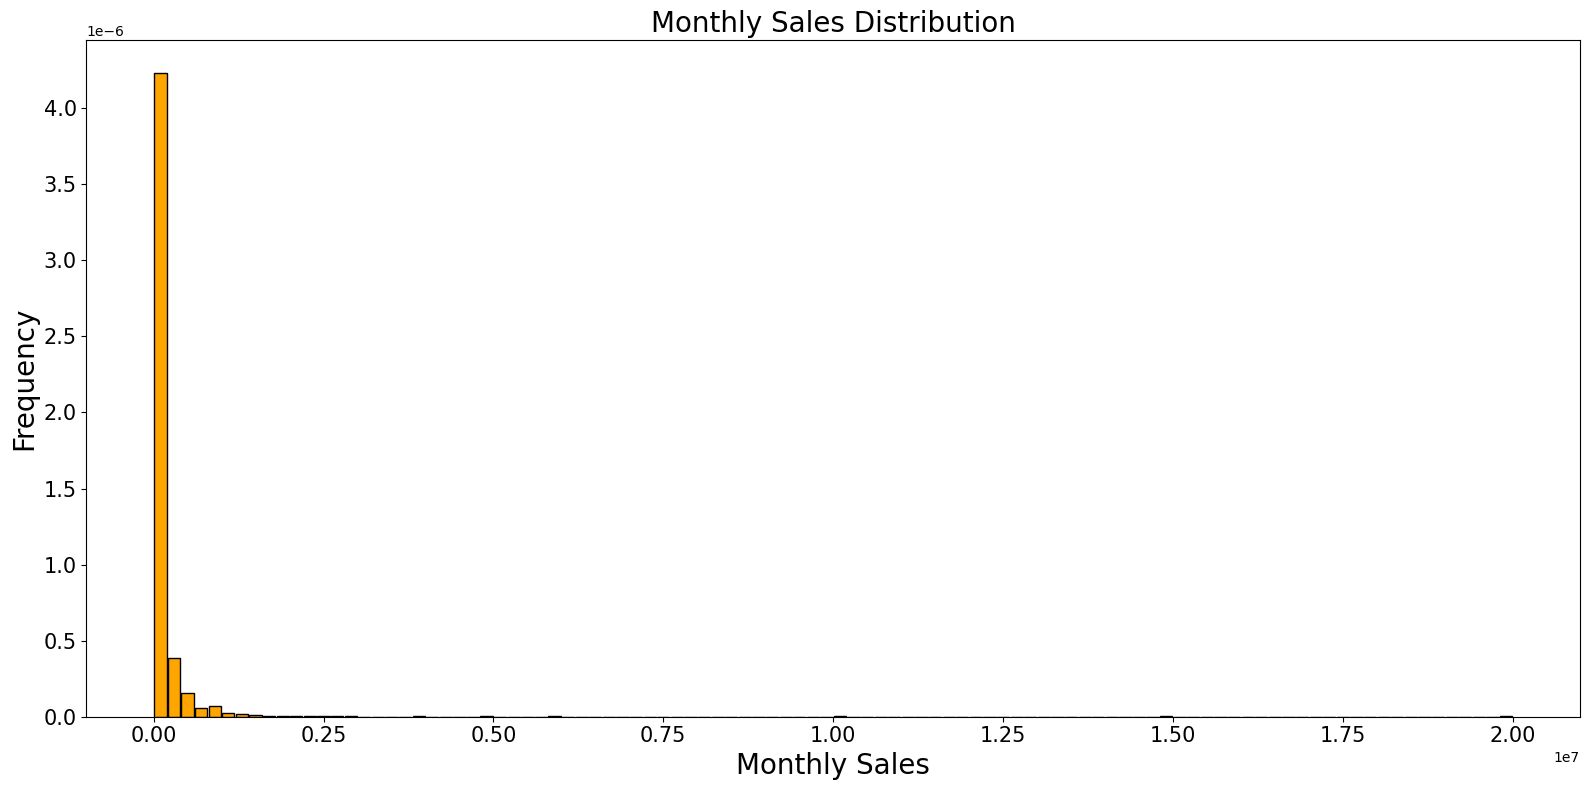

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(nuvemshop_dataset['Monthly Sales'], bins=100, color="orange", rwidth=0.9, edgecolor='black', density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Monthly Sales', fontsize=20)
plt.title('Monthly Sales Distribution', fontsize=20)
fig.tight_layout()

The image shows a histogram representing the distribution of monthly sales values. The data is concentrated at lower values, with a long tail towards higher values, indicating an asymmetric distribution (right-skewed distribution). The understanding of *outliers* is essential since some intepretations are possible, for example:

* Premium Clients (companies that make very high-value purchases, they can be the most profitable segment and, therefore, require special attention)
* High-Risk (companies that make occasional high-value purchases)
* Anomalies (such as fraud, unlikely in this case, but still a possibility)



In [12]:
outliers = detect_outliers(nuvemshop_dataset['Monthly Sales'])

In [13]:
print('The upper bound for the outliers is:', outliers['upper_bound'])
print('The percentage of outliers is:', outliers['percentage'])

The upper bound for the outliers is: 266796.54000000004
The percentage of outliers is: 11.301671064204045


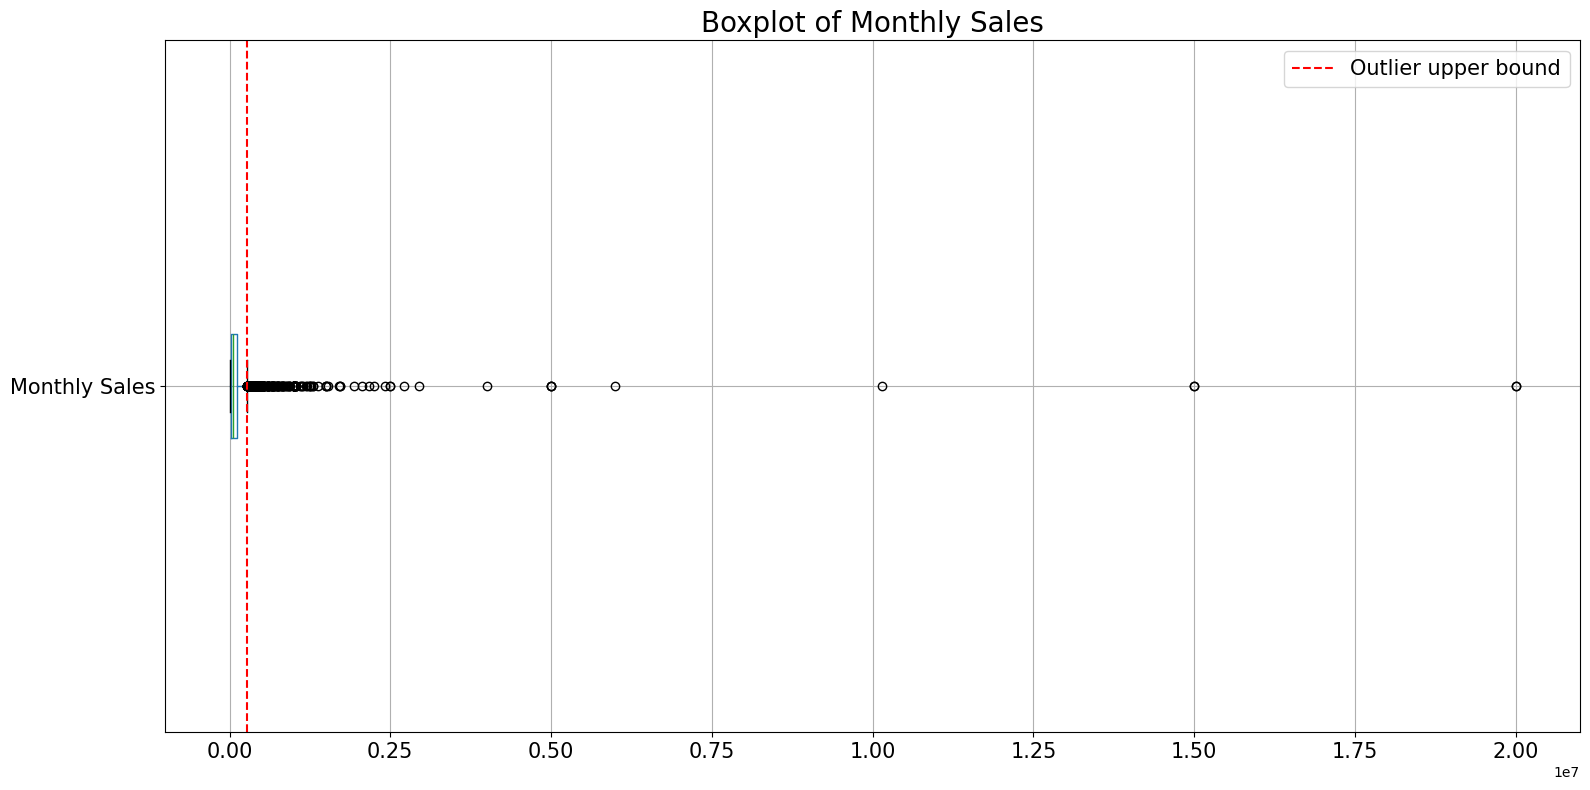

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
nuvemshop_dataset.boxplot(column='Monthly Sales', ax=ax, vert=False)
plt.xticks(fontsize=15)
plt.axvline(outliers['upper_bound'], color='red', linestyle='--', label='Outlier upper bound')
plt.yticks(fontsize=15)
plt.title('Boxplot of Monthly Sales', fontsize=20)
plt.legend(fontsize=15)
fig.tight_layout()
plt.show()

Outliers make up approximately 11% of the dataset. Let’s examine their features to understand why their values are significantly higher compared to the rest of the dataset.

In [15]:
outliers_df = nuvemshop_dataset[nuvemshop_dataset['Monthly Sales'] > outliers['upper_bound']]
outliers_df.shape

(257, 27)

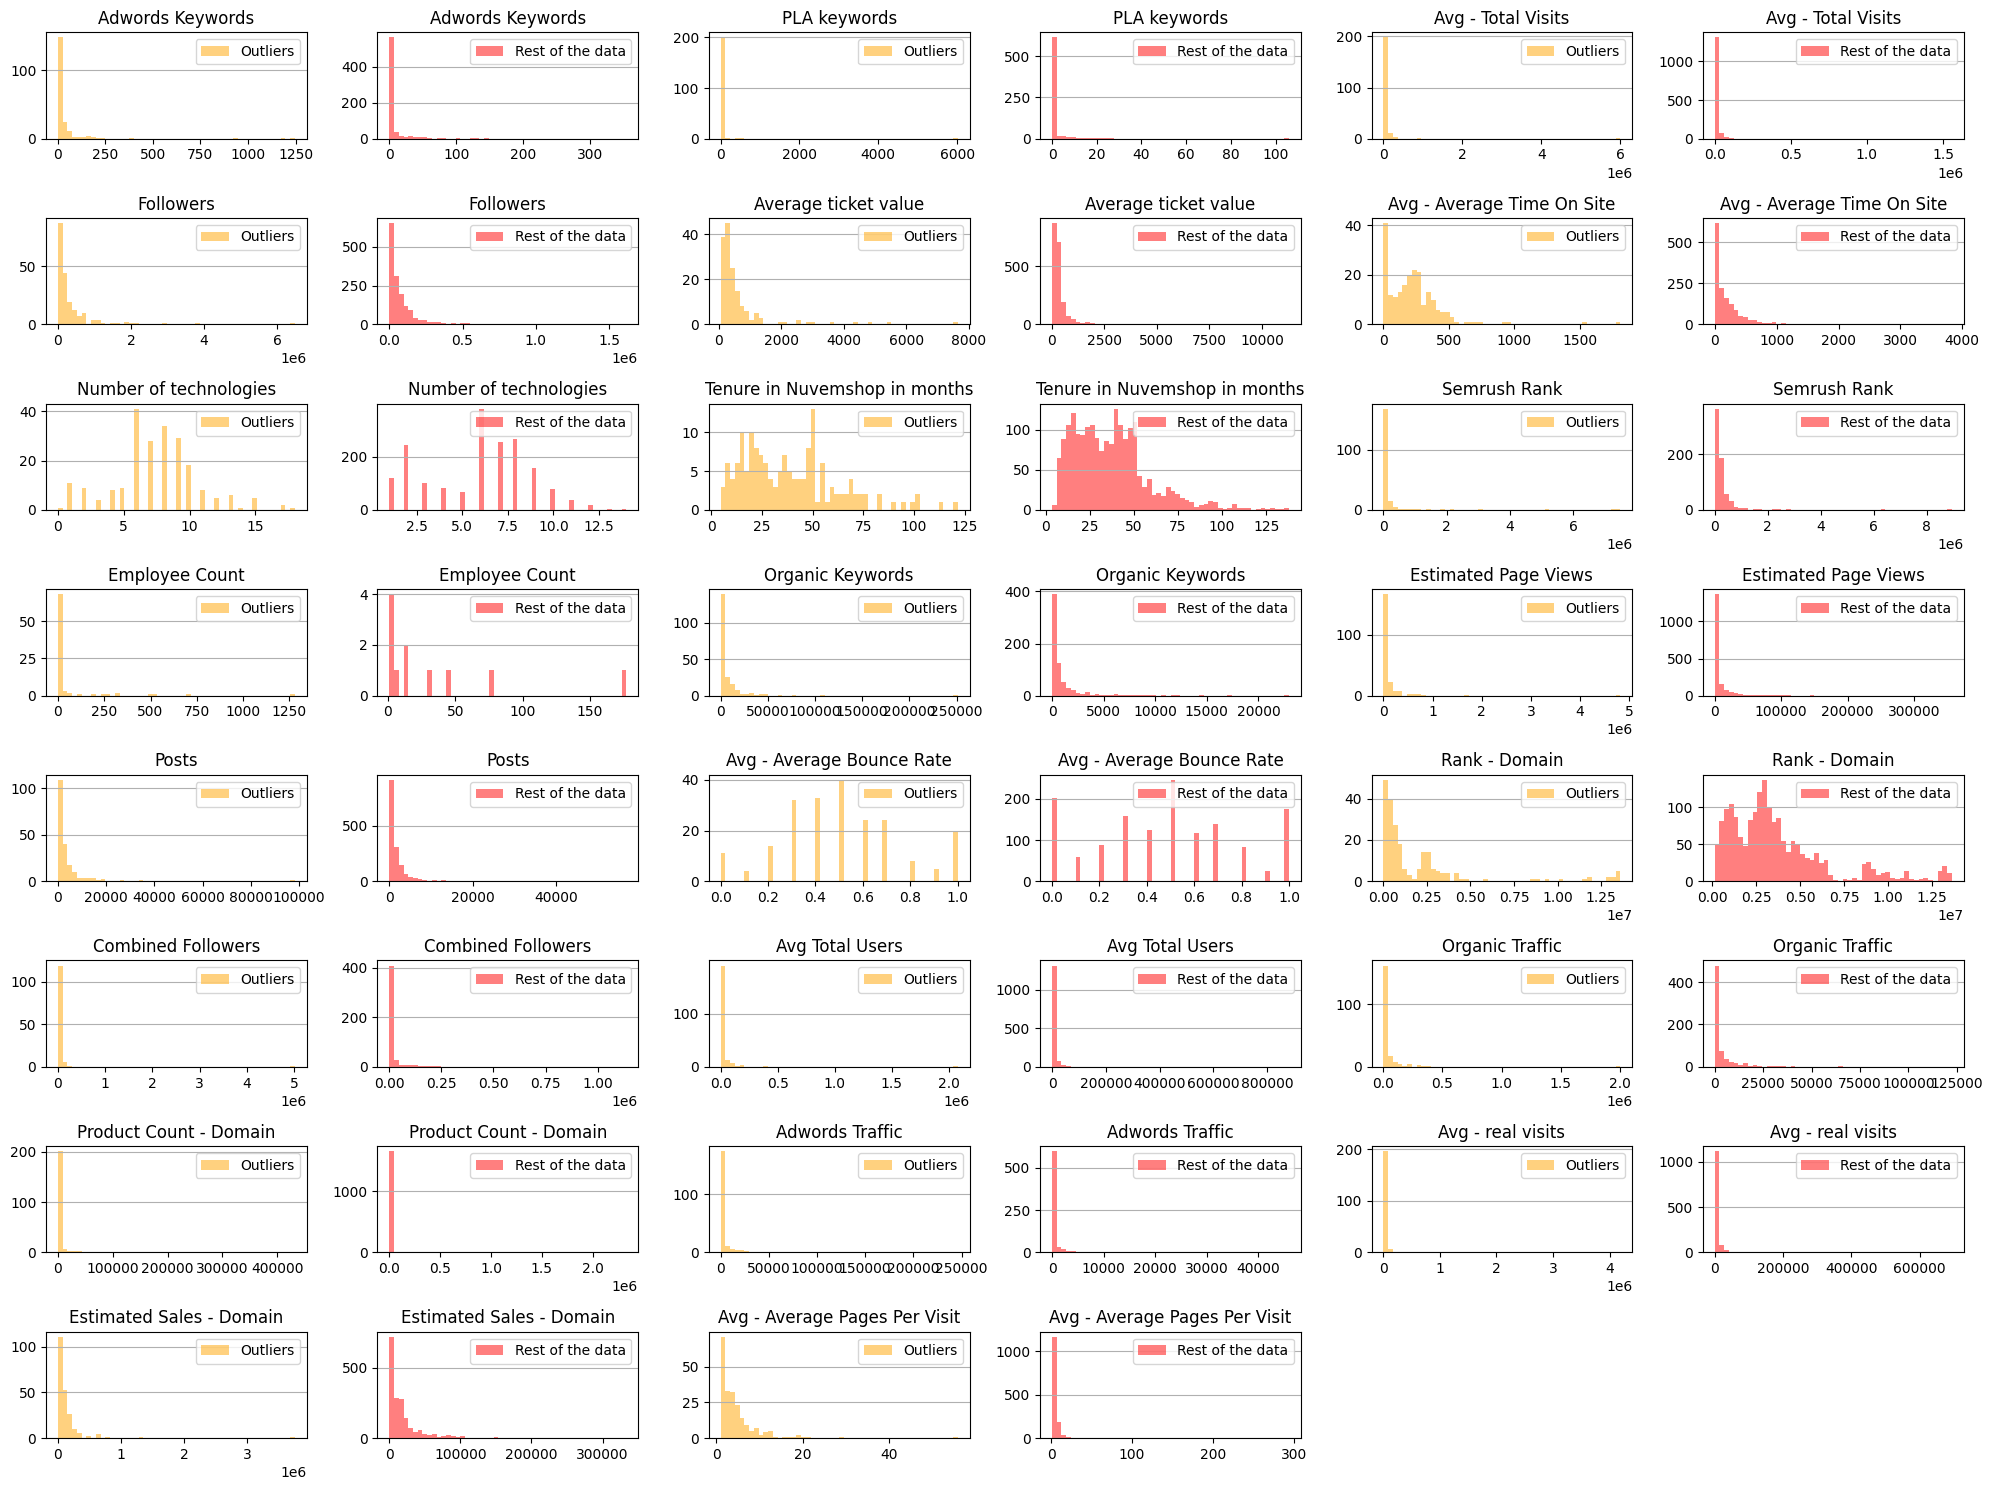

In [16]:
feature_to_plot = outliers_df.drop(['ID', 'Current plan id', 'Monthly Sales', 'log_monthly_sales'], axis=1).columns
rest_of_the_data = nuvemshop_dataset.drop(outliers_df.index)
plot_comparative_histograms(
    dataset1=outliers_df[feature_to_plot],
    dataset2=rest_of_the_data[feature_to_plot],
    n_cols=3,
    n_rows=8,
    color1='orange',
    color2='red',
    label1='Outliers',
    label2='Rest of the data',
)

We can use the Komogorov-Smirnov test to check if the distributions of the features are different between the outliers and the rest of the data

In [17]:
for feature in feature_to_plot:
    ks_statistic, p_value = stats.ks_2samp(outliers_df[feature], rest_of_the_data[feature])
    if p_value < 0.05:
        print(f'The {feature} distribution is statistically different between the outliers and the rest of the data')

The results above indicate that no feature effectively distinguishes the outliers from the rest of the data. Let's apply correlation analysis

## Correlation Analysis

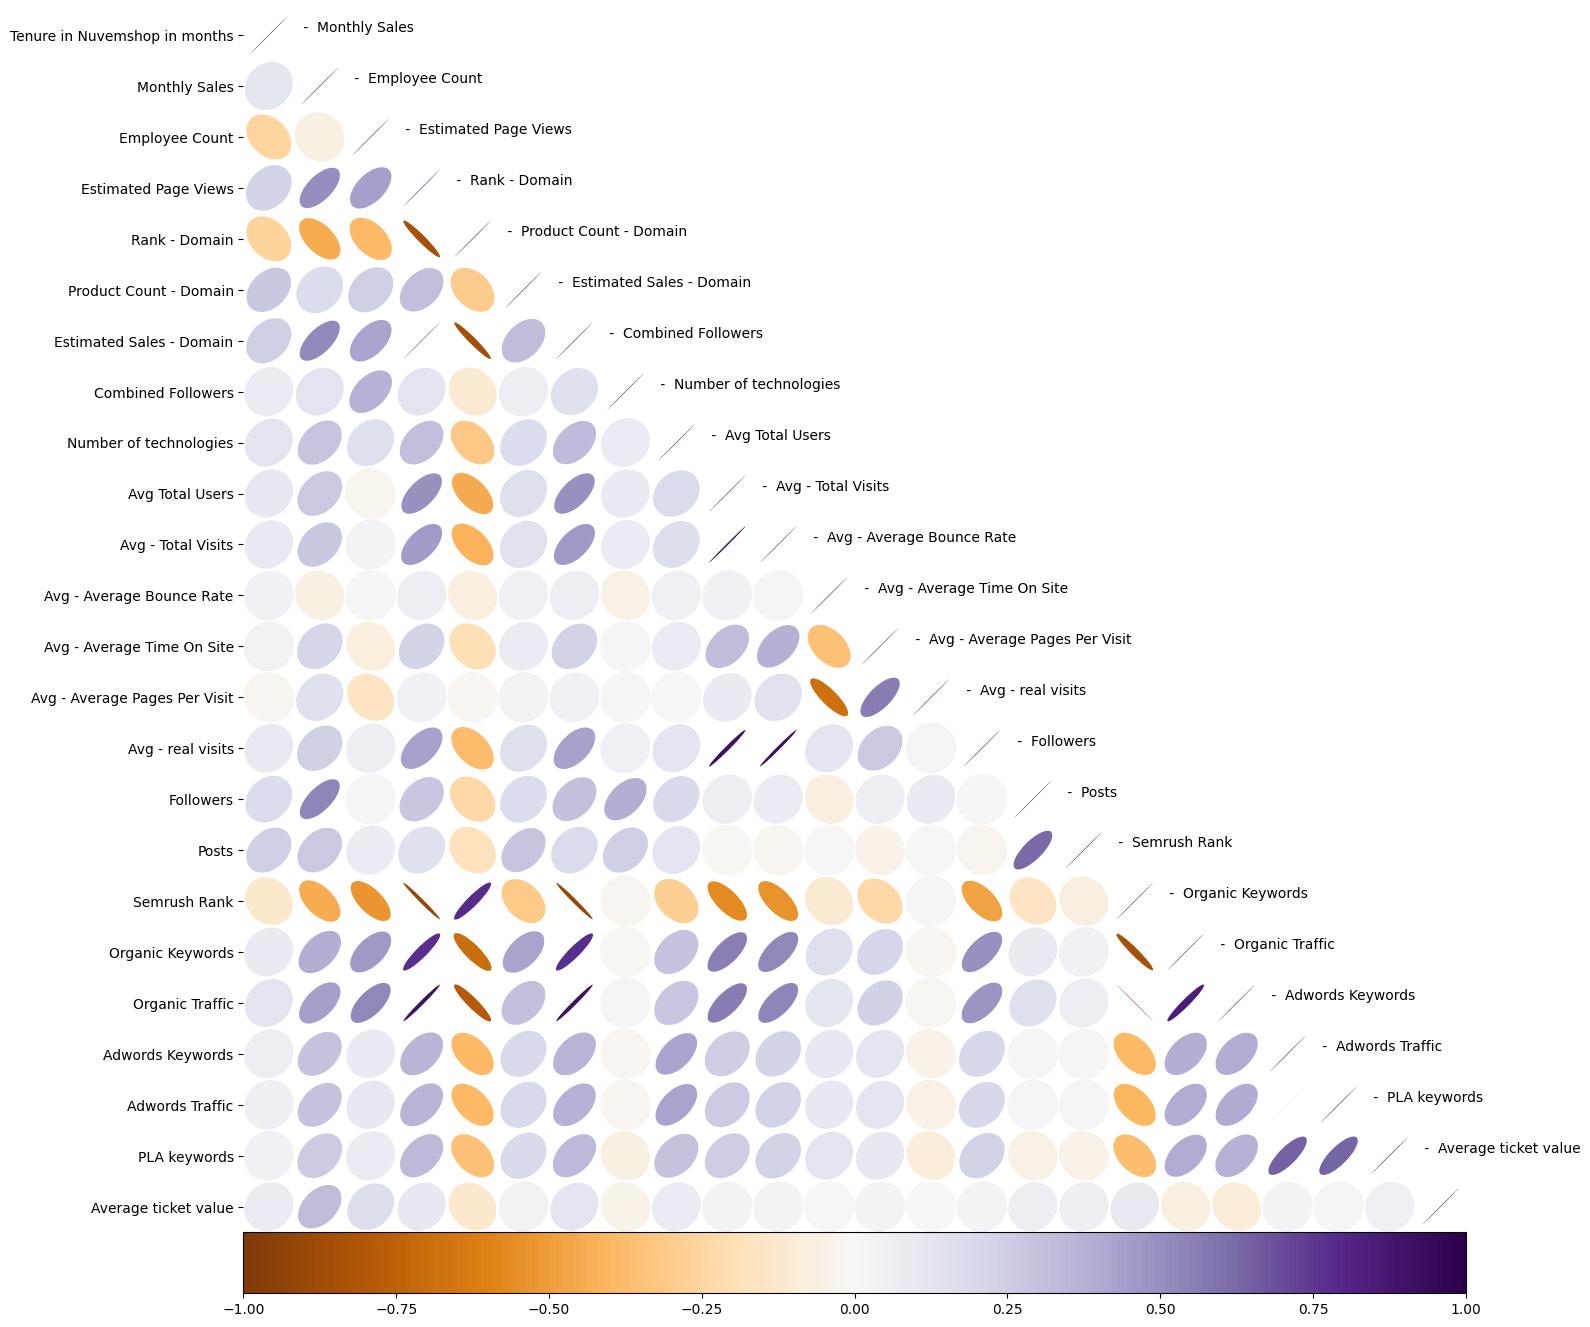

In [18]:
correlation_matrix = nuvemshop_dataset.drop(['ID', 'Current plan id', 'log_monthly_sales'], axis=1).corr(method='spearman')

# Use the function with the Spearman correlation matrix
ec, ax = plot_corr_ellipses(correlation_matrix, figsize=(16, 32), cmap='PuOr')
plt.tight_layout()
plt.show()

We created a unique heatmap using ellipses to visualize the correlation between each feature more effectively. Specifically, we used Spearman correlation for this analysis. The orientation of the ellipse indicates whether two variables are positively correlated (pointing to the top right) or negatively correlated (pointing to the top left). Additionally, the shading and width of the ellipse reflect the strength of the association: thinner and darker ellipses represent stronger relationships.

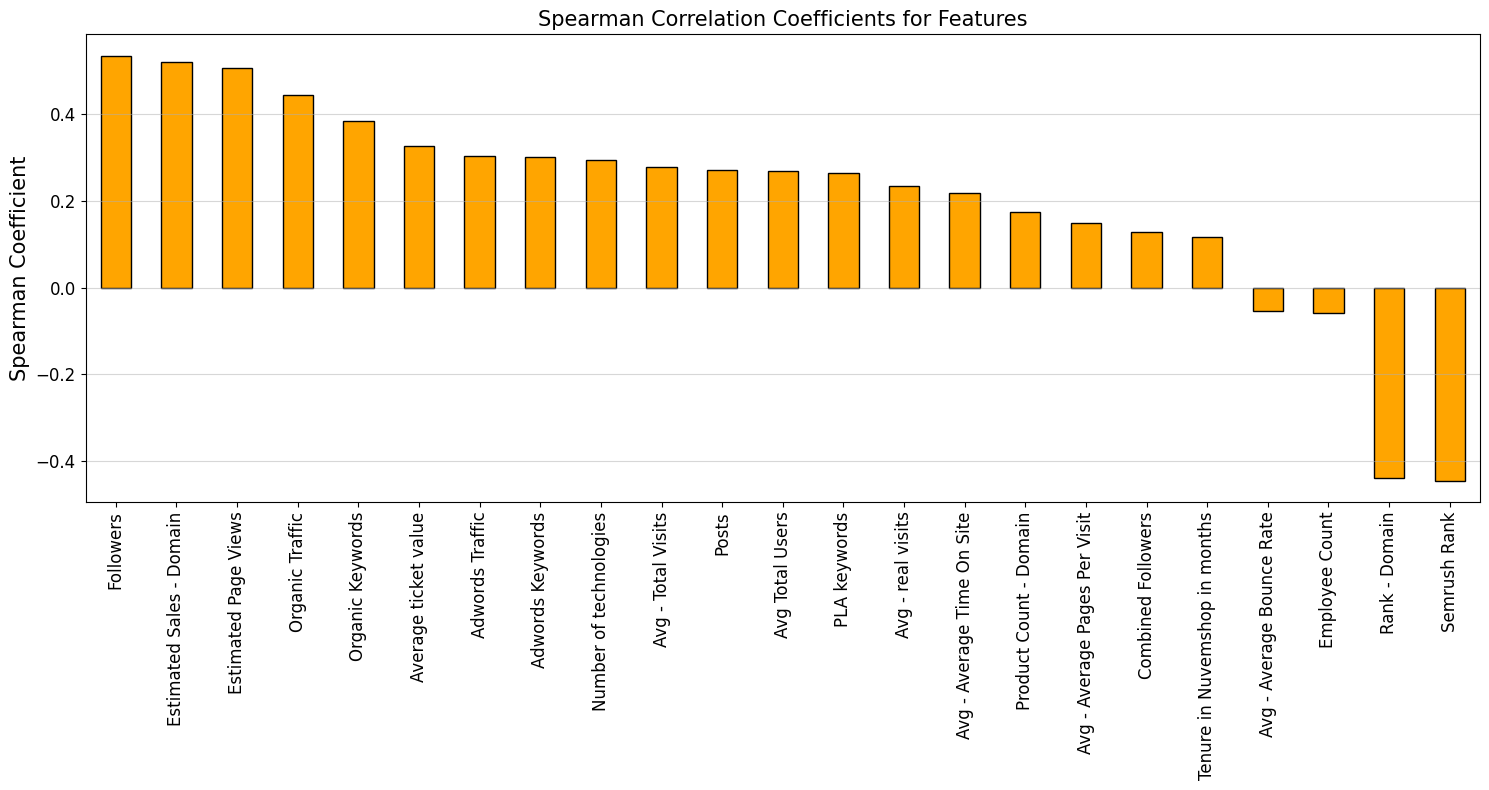

In [19]:
spearman_corr_results = nuvemshop_dataset.drop(['ID', 'Current plan id', 'log_monthly_sales'], axis=1).corr(method='spearman')['Monthly Sales'].drop('Monthly Sales').to_frame()
spearman_corr_results = spearman_corr_results.reset_index()
spearman_corr_results.columns = ['Features', 'spearman_corr']

spearman_corr_results = spearman_corr_results.sort_values(by='spearman_corr', ascending=False)
fig, ax = plt.subplots(figsize=(15,8))
spearman_corr_results['spearman_corr'].plot(
    kind='bar', edgecolor='black', color='orange', ax=ax
)
ax.set_xticklabels(spearman_corr_results.Features.values, rotation=90, fontsize=12)
ax.set_ylabel('Spearman Coefficient', fontsize=15)
ax.set_title('Spearman Correlation Coefficients for Features', fontsize=15)
plt.grid(True, axis='y', alpha=0.5)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We see the most prominent features to be those with correlation values above 0.4 or below -0.4, as they exhibit a strong relationship with the target variable. These features are:

- Followers  
- Estimated Sales - Domain  
- Estimated Page Views  
- Organic Traffic  
- Rank - Domain  
- Semrush Rank

Before performing clustering to identify potential segmentation candidates, let’s analyze the relationship between `Rank - Domain` and `Semrush Rank`.

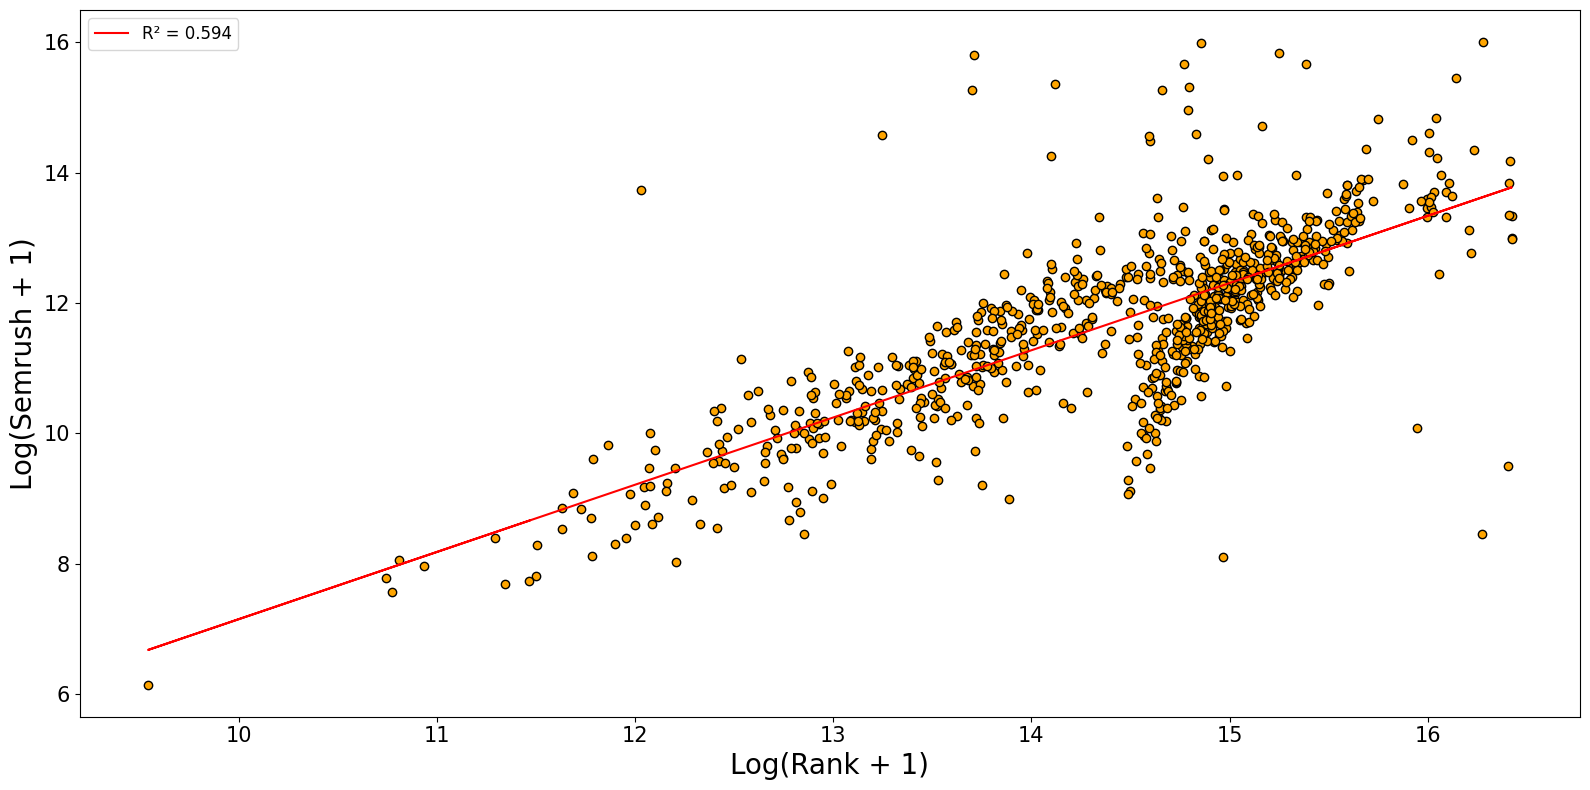

Slope (Log-transformed): 1.0315
Intercept (Log-transformed): -3.1653
R-squared (Log-transformed): 0.5938


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Remove NaN values
rank_data = nuvemshop_dataset[['Rank - Domain', 'Semrush Rank']].dropna()

# Log transformation
x_log = np.log1p(rank_data['Rank - Domain'])
y_log = np.log1p(rank_data['Semrush Rank'])

# Create scatter plot with regression line
fig, ax = plt.subplots(figsize=(16, 8))

# Scatter plot of log-transformed data
plt.scatter(x_log, y_log, color='orange', edgecolor='black')

# Linear Regression on log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(x_log, y_log)

# Regression line
line = slope * x_log + intercept
plt.plot(x_log, line, color='red', label=f'R² = {r_value**2:.3f}')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Log(Rank + 1)', fontsize=20)
plt.ylabel('Log(Semrush + 1)', fontsize=20)
plt.legend(fontsize=12)
fig.tight_layout()
plt.show()

# Print regression statistics
print(f"Slope (Log-transformed): {slope:.4f}")
print(f"Intercept (Log-transformed): {intercept:.4f}")
print(f"R-squared (Log-transformed): {r_value**2:.4f}")

The scatterplot shows the relationship between the `Rank - Domain` and `Semrush Rank`. The red line represents the linear regression fit, with an $R^2$ value of 0.594, indicating a moderate positive correlation between these two features. This suggests that higher domain ranks are generally associated with higher Semrush ranks. So, after this point we will work only with `Rank - Domain` variable.

Next, we will apply a clustering algorithm to the `log_monthly_sales` to explore whether clusters can be identified.

## Clustering

In [21]:
from sklearn.cluster import KMeans
feats_to_cluster = ['log_monthly_sales']
X_cluster = nuvemshop_dataset[['log_monthly_sales']].values
sse=[]
for i in range(1,7):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X_cluster)
    sse.append(kmeans.inertia_)

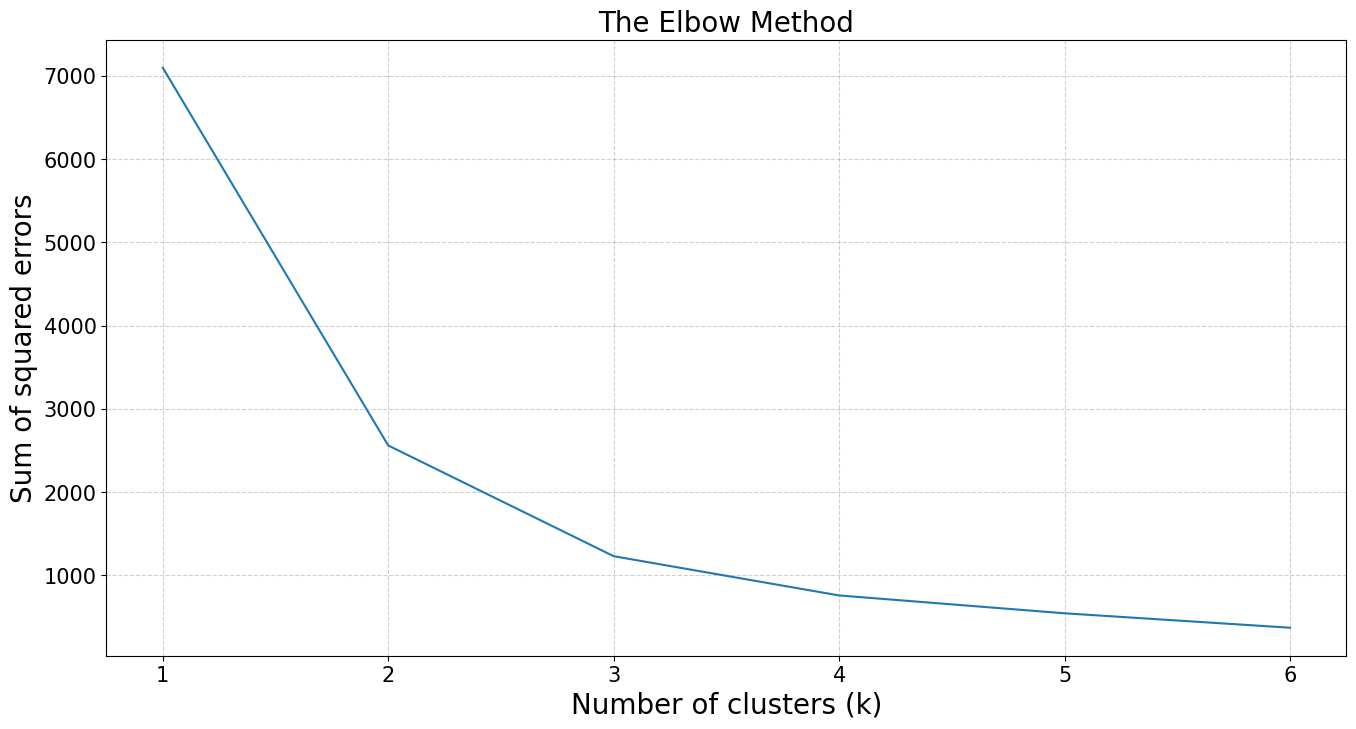

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(range(1,7), sse)
plt.title('The Elbow Method', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Number of clusters (k)', fontsize=20)
plt.ylabel('Sum of squared errors', fontsize=20)
plt.show()

In the Elbow Method graph, the point where the curve experiences the most significant change in slope typically indicates the optimal number of clusters. In this case, the "elbow" appears to be at **k = 2**, as there is a significant drop in error up to this point, followed by a more gradual decrease in subsequent values.

In [23]:
kmeansmodel = KMeans(n_clusters= 2, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X_cluster)

Silhouette Score: 0.67


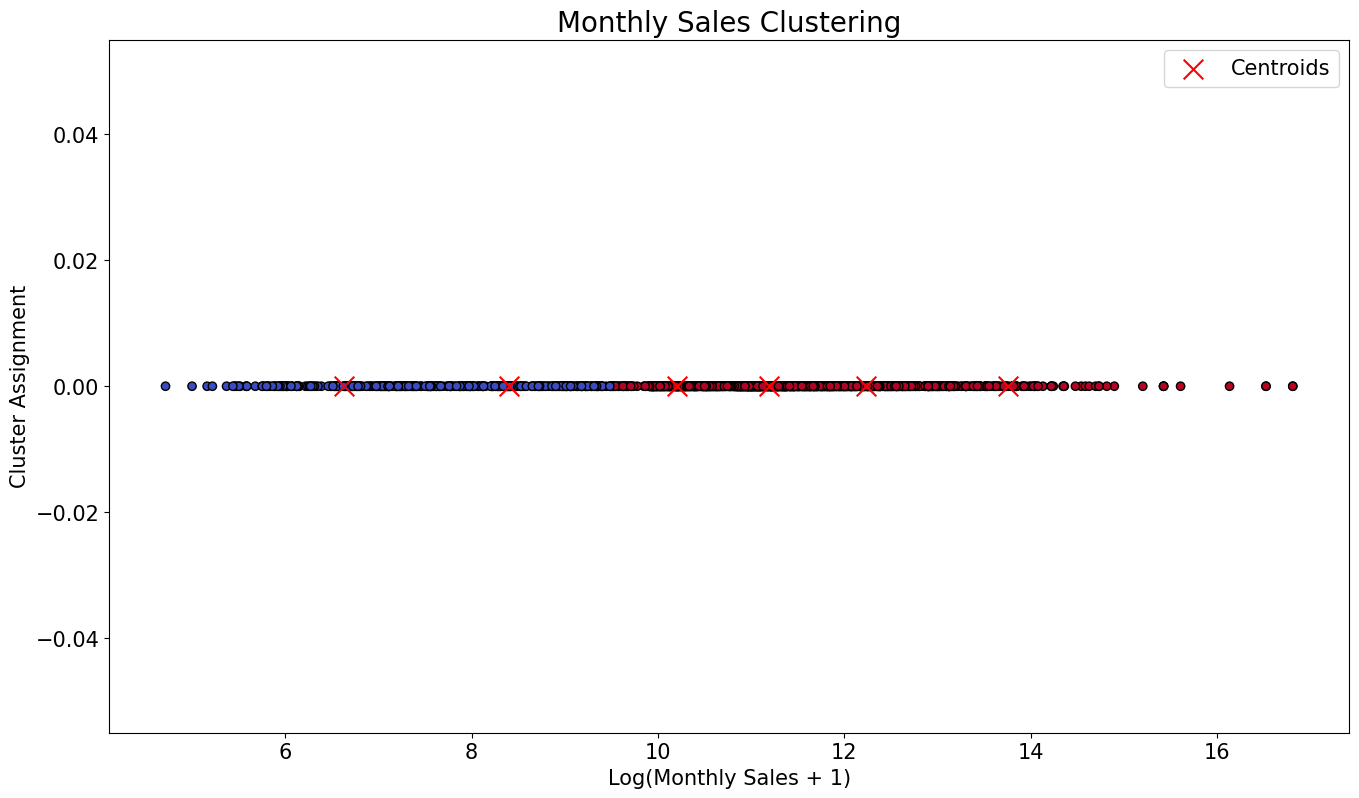

In [24]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(X_cluster, y_kmeans)
print(f'Silhouette Score: {silhouette:.2f}')

# Visualize clusters
plt.figure(figsize=(16, 9))
plt.scatter(X_cluster, [0] * len(X_cluster), c=y_kmeans, edgecolors='black', cmap='coolwarm_r')
plt.scatter(kmeans.cluster_centers_[:, 0], [0] * len(kmeans.cluster_centers_), c='red', marker='x', s=200, label='Centroids')
plt.title('Monthly Sales Clustering', fontsize=20)
plt.xlabel('Log(Monthly Sales + 1)', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Cluster Assignment', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Let's analyze how the prominent features are distributed across the two segments of `Monthly Sales`.

In [25]:
nuvemshop_dataset['label_kmeans'] = y_kmeans

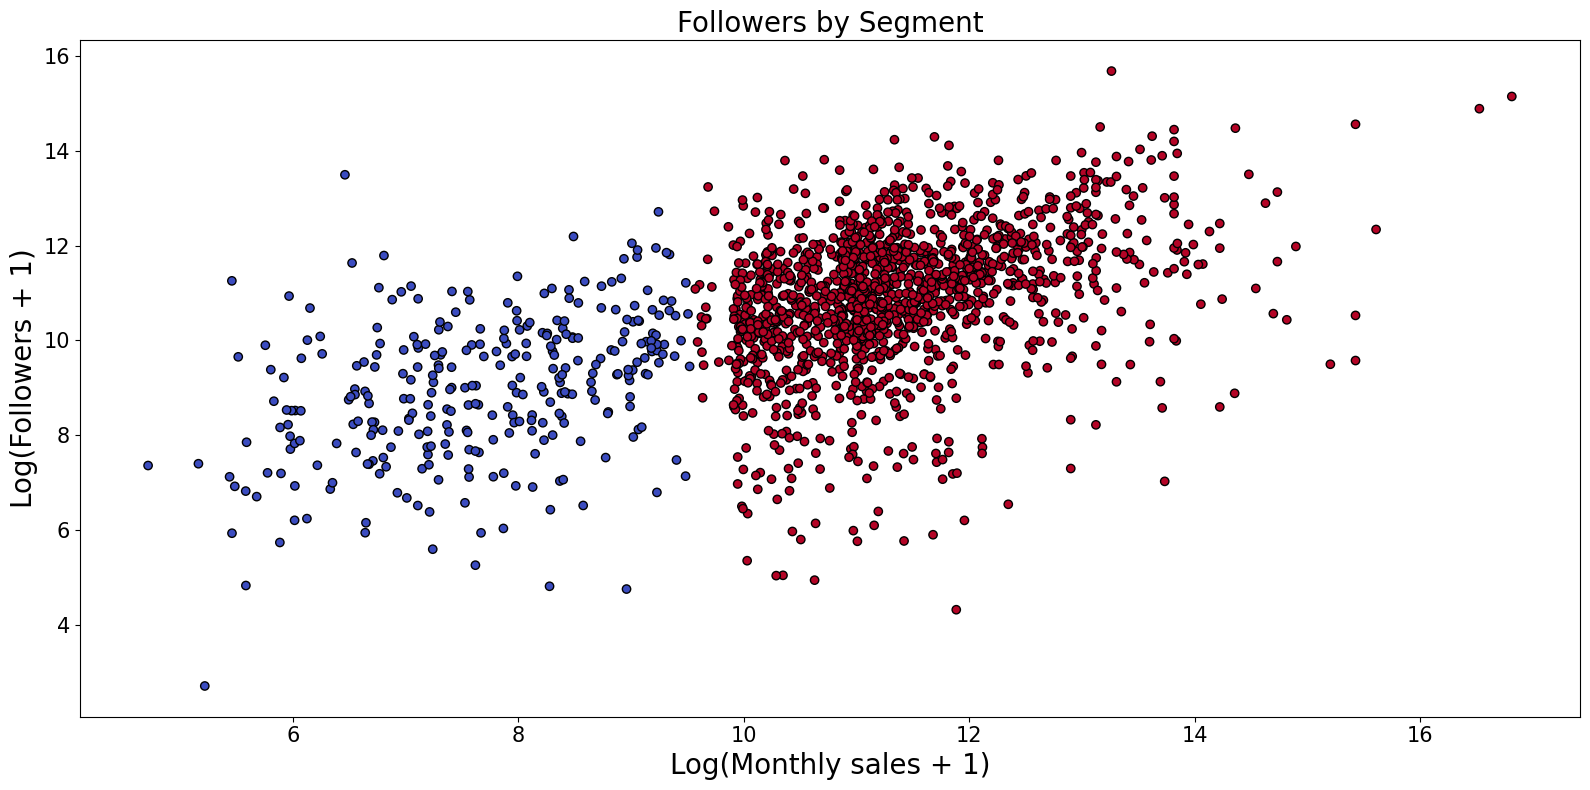

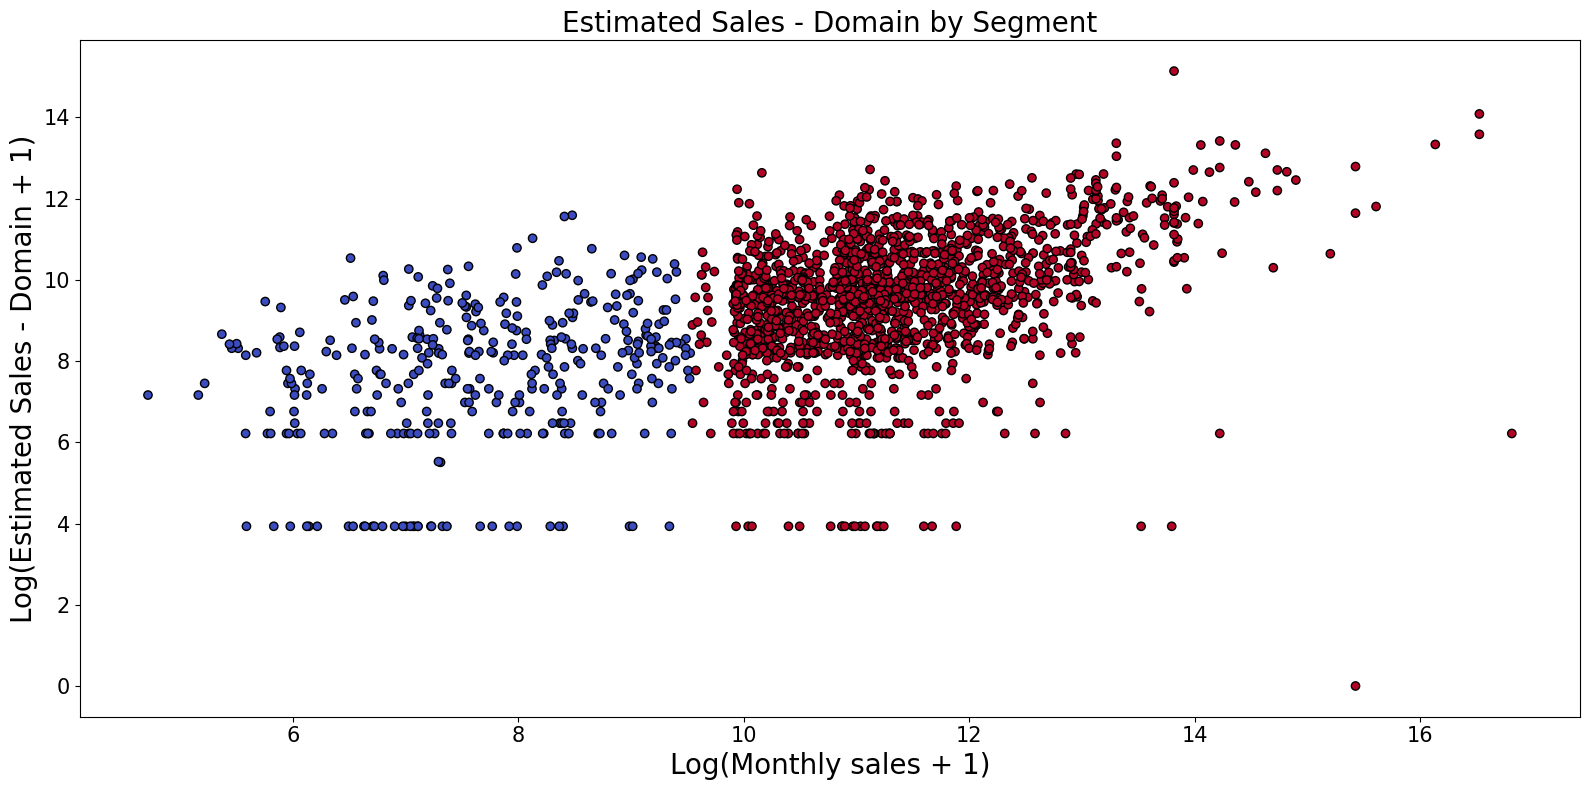

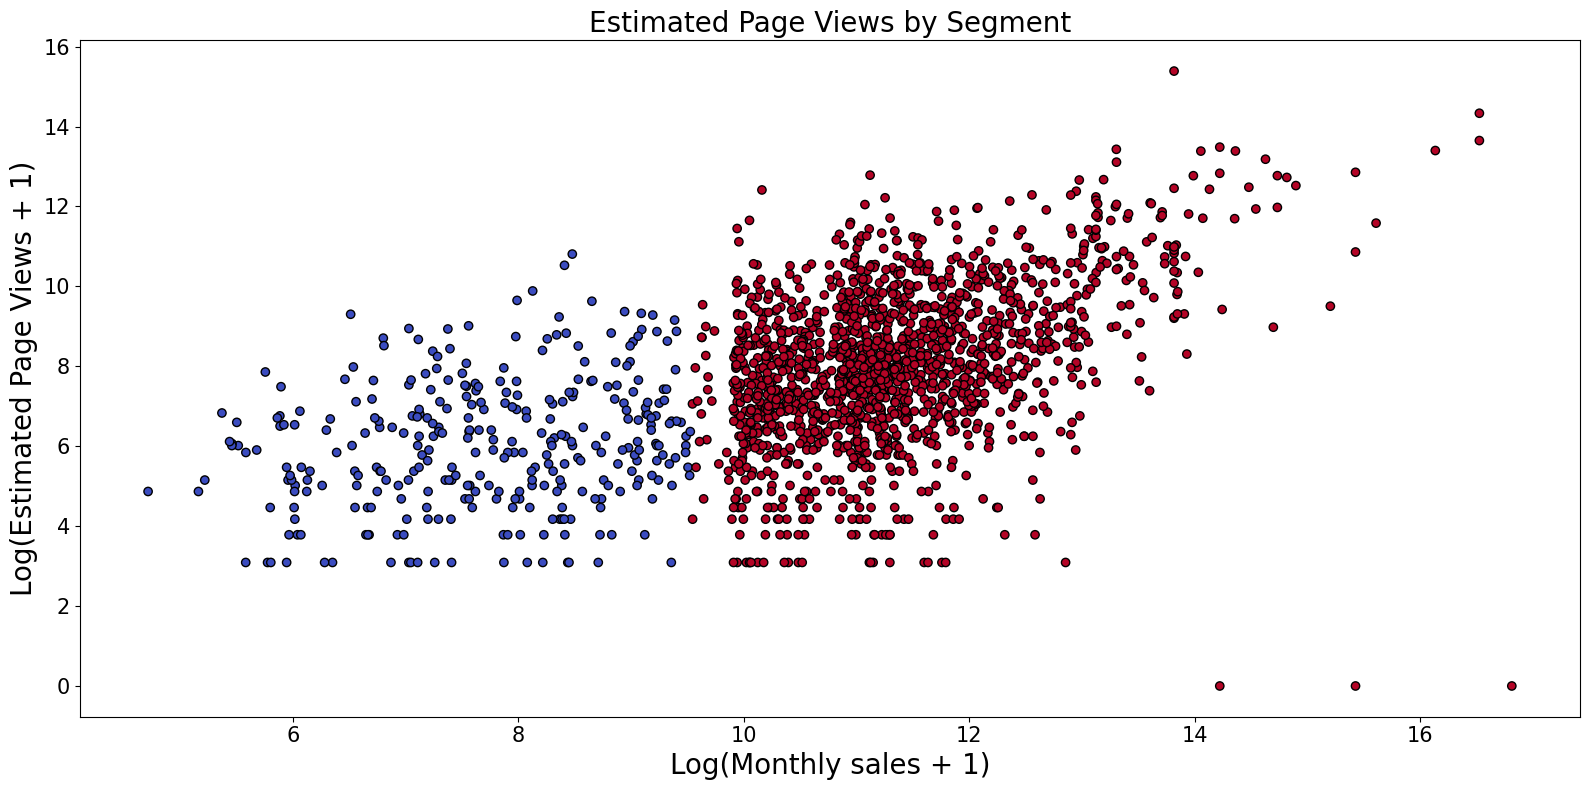

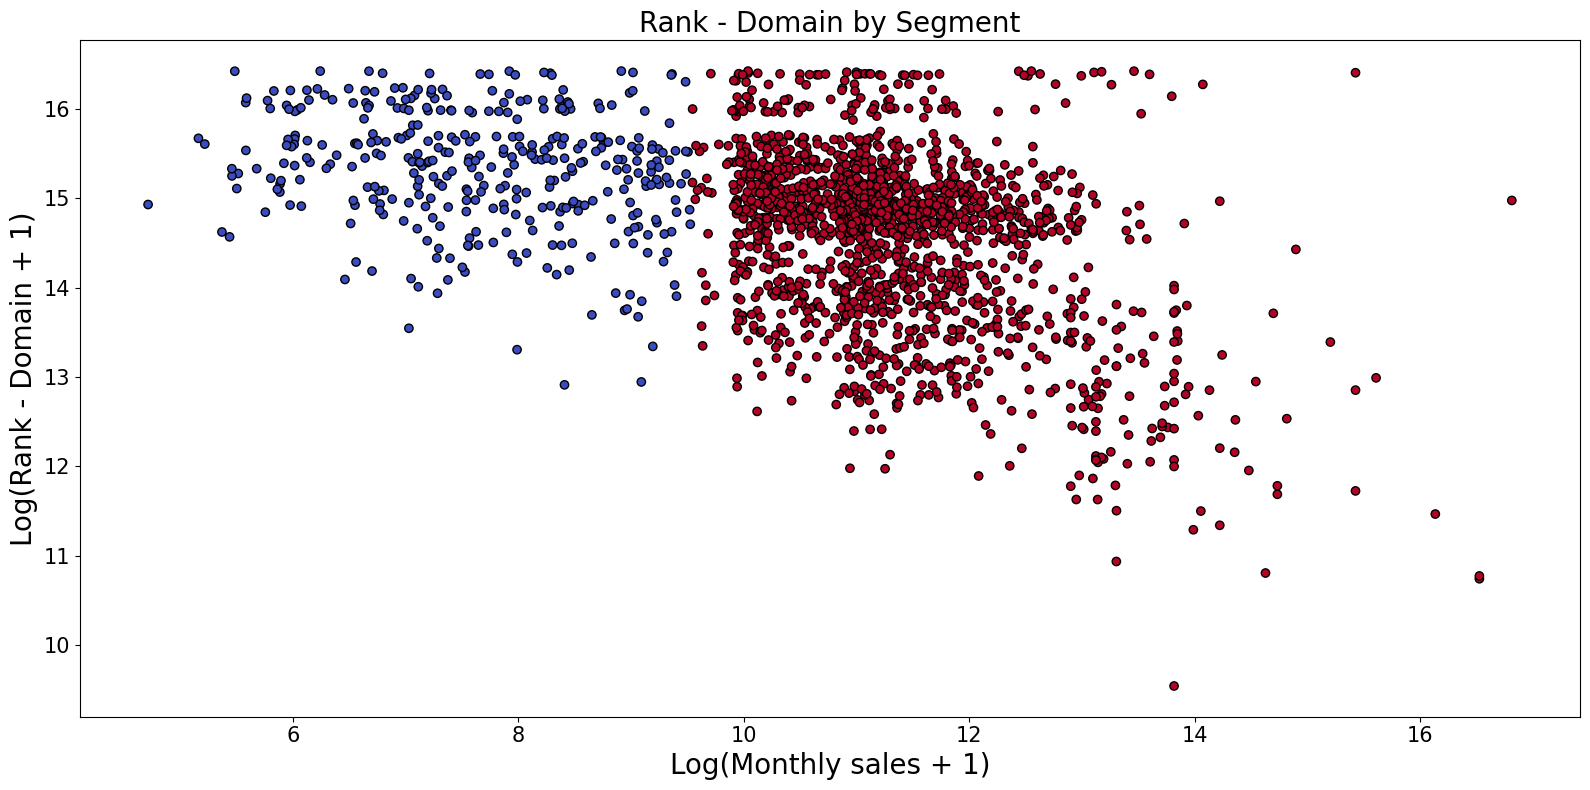

In [26]:
proeminent_features = [
  'Followers',
  'Estimated Sales - Domain',
  'Estimated Page Views',
  'Rank - Domain' 
]

for feature in proeminent_features:
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.scatter(nuvemshop_dataset['log_monthly_sales'], np.log1p(nuvemshop_dataset[feature]), c=nuvemshop_dataset['label_kmeans'], cmap='coolwarm_r', edgecolors='black')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Log(Monthly sales + 1)', fontsize=20)
    plt.ylabel(f'Log({feature} + 1)', fontsize=20)
    plt.title(f'{feature} by Segment', fontsize=20)
    fig.tight_layout()
    plt.show()

**General Relationship:**
- There is a **positive correlation** between the number of `Followers`, `Estimated Sales`, `Estimated Views` and `Monthly Sales`: companies with more followers tend to achieve higher sales.
- This trend highlights the importance of social media engagement as a key factor for driving sales, particularly for companies in the red segment.

**Insights:**
- Companies in the blue segment could benefit from strategies aimed at increasing social media engagement, which may help boost their sales.
- On the other hand, companies in the red segment should focus on maintaining or further expanding their follower base, as it appears to be consistently associated with higher sales performance.
- A high rank on Google (worse position) does not prevent companies in the red segment from achieving high sales, suggesting that factors like branding or other acquisition channels play a more important role for them. On the other hand, companies in the blue segment not only rank poorly but also show lower sales performance, indicating a need for improvements in digital strategies.

# Modeling

We have observed that logarithmic transformations can help normalize data, particularly by addressing the impact of outliers. This adjustment can improve the accuracy of statistical tests and make the data more suitable for modeling. However, logarithmic transformation is just one specific case of a broader feature transformation method known as `Box-Cox`, which can be defined as:

\begin{equation}
f_{\text{BoxCox}}(x) =
\begin{cases}
    \frac{{x^\lambda - 1}}{{\lambda}}, & \text{if } \lambda \neq 0 \\
    \log(x), & \text{if } \lambda = 0
\end{cases}
\end{equation}


where $x$ is the input variable and $\lambda$ is the transformation parameter. The appropriate choice of $\lambda$ is crucial and is typically determined to maximize the normality of the transformed data.

In [27]:
features_to_transform = nuvemshop_dataset.drop(['ID', 'log_monthly_sales', 'label_kmeans', 'Current plan id', 'Monthly Sales'], axis=1).columns
for feature in features_to_transform:
    # First we need to fill the NaN values, e.g., with the median
    nuvemshop_dataset.loc[:, f'{feature}_boxcox'] = nuvemshop_dataset[feature].fillna(nuvemshop_dataset[feature].median())
    

In [28]:
for feature in features_to_transform:
    nuvemshop_dataset[f'{feature}_boxcox'] = nuvemshop_dataset[f'{feature}_boxcox'].replace(0 , 1e-10)
    nuvemshop_dataset[f'{feature}_boxcox'], _ = boxcox(nuvemshop_dataset[f'{feature}_boxcox'])

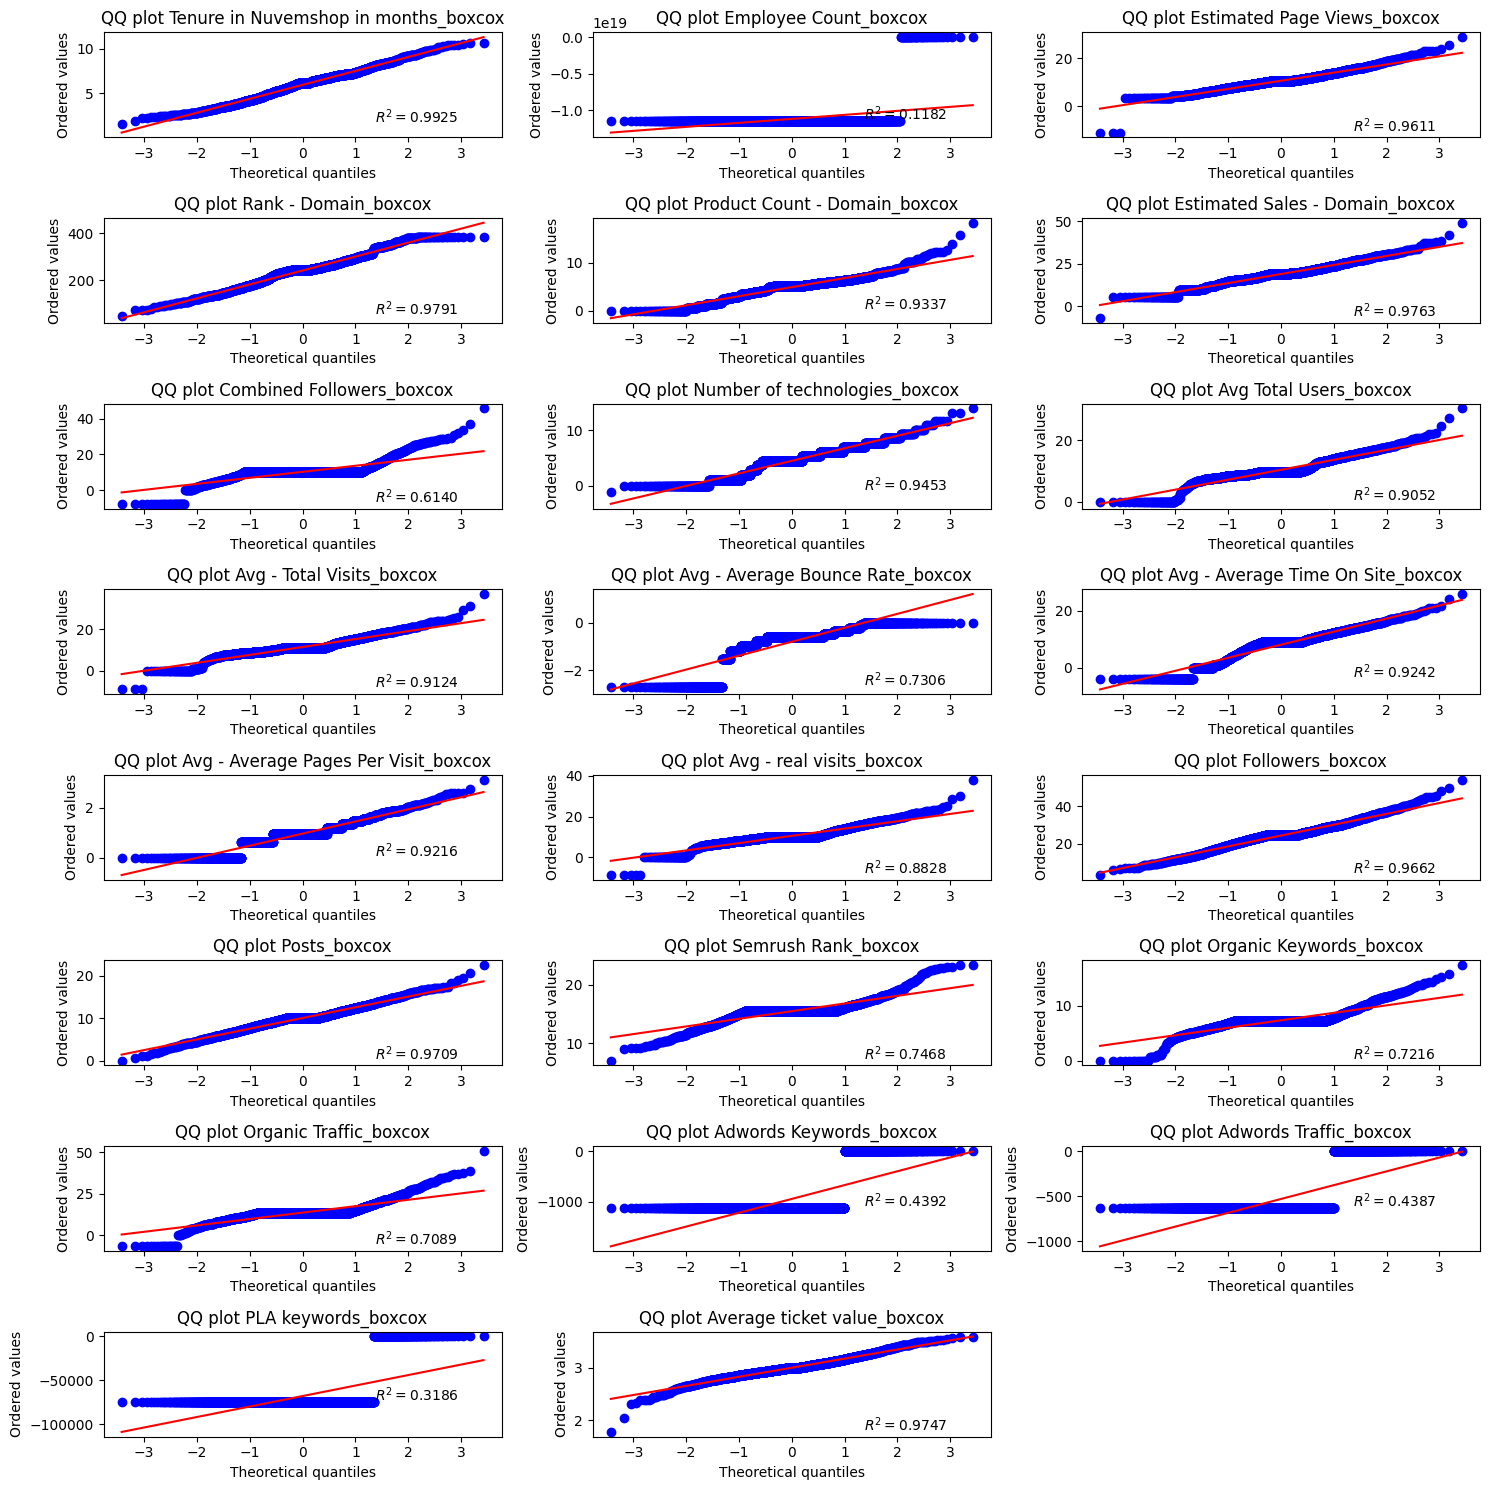

In [29]:
qq_plot(
    qq_df=nuvemshop_dataset[
        [ f'{f}_boxcox' for f in features_to_transform]
    ],
    n_rows=8,
    n_cols=3
)

To assess the normality of the transformed data, we can conduct a *Kolmogorov-Smirnov* test.

In [30]:
from utils.stats import KSTest

ks_df = pd.DataFrame()

ks_df['boxcox feature'] = [f"{f}_boxcox" for f in features_to_transform]

ks_test = KSTest(
    data=nuvemshop_dataset[[f"{f}_boxcox" for f in features_to_transform]]
)

ks_df['p-value'] = [p for p in ks_test.get_p_values().values()]
ks_df['shapiro test'] = [ks_test.is_feature_normal(f) for f in ks_df['boxcox feature']]

ks_df

,boxcox feature,p-value,shapiro test
0,Tenure in Nuvemshop in months_boxcox,0.0,False
1,Employee Count_boxcox,0.0,False
2,Estimated Page Views_boxcox,0.0,False
3,Rank - Domain_boxcox,0.0,False
4,Product Count - Domain_boxcox,0.0,False
5,Estimated Sales - Domain_boxcox,0.0,False
6,Combined Followers_boxcox,0.0,False
7,Number of technologies_boxcox,0.0,False
8,Avg Total Users_boxcox,0.0,False
9,Avg - Total Visits_boxcox,0.0,False


The Shapiro test results indicate that the **transformed data does not conform to a Gaussian distribution**. Therefore, we retain the features in their original form.

CatBoost is a powerful machine learning library that handles missing data (NaN) effectively, offering built-in mechanisms to manage these values seamlessly during model training. This makes it an excellent choice for datasets with incomplete information. Additionally, CatBoost is robust in addressing epistemic uncertainty—uncertainty arising from the lack of knowledge or data—by leveraging its gradient boosting framework to generalize well and provide reliable predictions even in complex scenarios

## Classification

In [31]:
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

Accuracy: 0.87
F1-score: 0.61
Precision: 0.69
Recall: 0.55


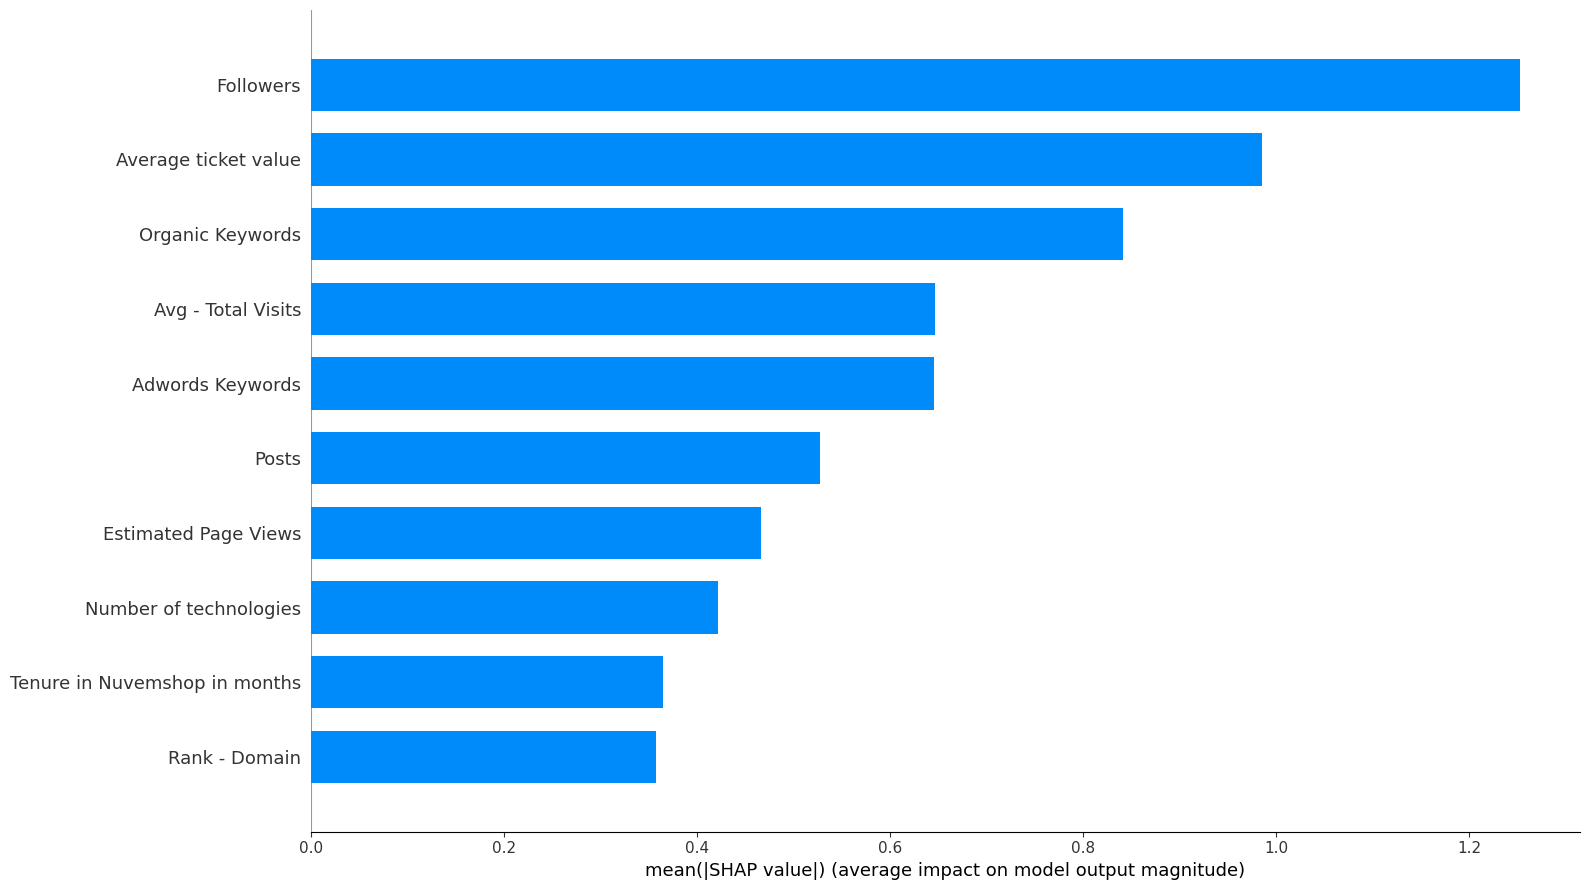

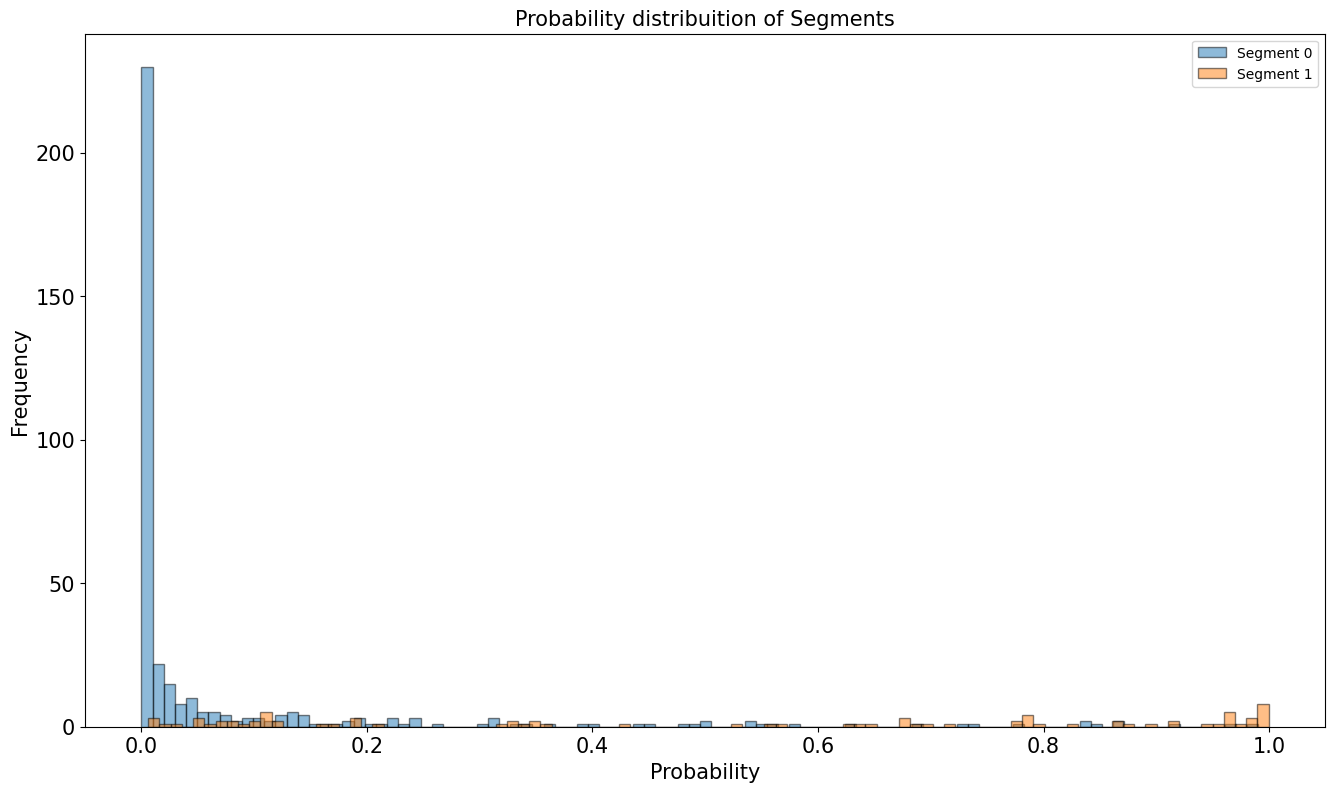

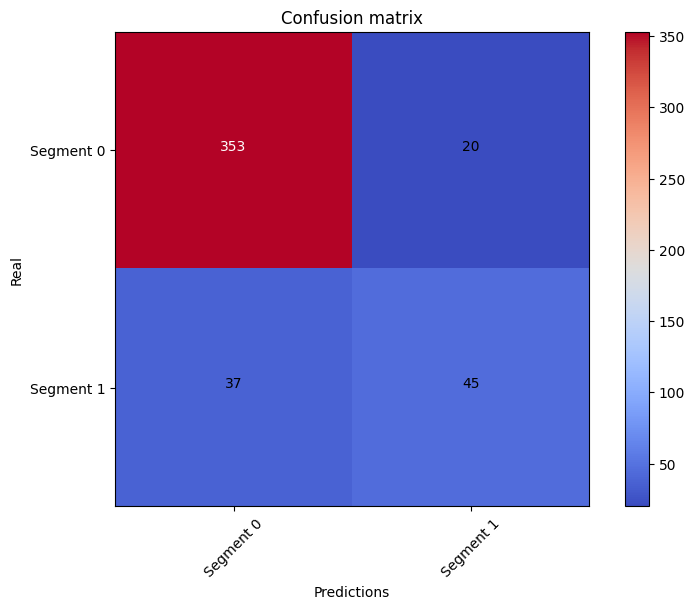

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       373
           1       0.69      0.55      0.61        82

    accuracy                           0.87       455
   macro avg       0.80      0.75      0.77       455
weighted avg       0.87      0.87      0.87       455



In [32]:
features_to_drop = ['ID', 'log_monthly_sales', 'label_kmeans', 'Current plan id', 'Monthly Sales', 'Semrush Rank'] + [f"{f}_boxcox" for f in features_to_transform] 
X = nuvemshop_dataset.drop(features_to_drop, axis=1)
y = nuvemshop_dataset['label_kmeans']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    learning_rate=0.1,
    depth=3,
    iterations=1000,
    verbose=False
)

# Train the model
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10, plot_size=(16, 9))

plt.figure(figsize=(16, 9))
plt.hist(y_proba[y_test == 0], bins=100, alpha=0.5, label='Segment 0', edgecolor='black')
plt.hist(y_proba[y_test == 1], bins=100, alpha=0.5, label='Segment 1', edgecolor='black')
plt.xlabel('Probability', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.title('Probability distribuition of Segments', fontsize=15)
plt.legend()
plt.show()

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.coolwarm)
plt.title('Confusion matrix')
plt.colorbar()


classes = ['Segment 0', 'Segment 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Real')
plt.xlabel('Predictions')
plt.show()

print(classification_report(y_test, y_pred))


## Insigths

1. **Feature Importance (SHAP values)**:
   - The most important features for the model are `Followers`, `Average ticket value`, `Organic Keywords`, and `Avg - Total Visits`. This indicates that these features have the greatest impact on segment prediction.
   - Variables related to digital presence (e.g., organic keywords and total visits) are as influential as economic factors such as average ticket value.

2. **Probability Distribution of Segments**:
   - The histogram shows a strong concentration in Segment 0, while Segment 1 has a lower representation. This indicates an imbalance in the dataset, with significantly more instances classified as Segment 0.

3. **Confusion Matrix**:
   - The model performs well in correctly identifying Segment 0 (353 true positives versus 20 false negatives).
   - For Segment 1, the performance is more limited, with only 45 true positives and 37 false negatives. This is reflected in the **Recall** (0.55), indicating that the model misses a significant number of actual Segment 1 instances.

4. **Overall Metrics**:
   - **Accuracy** (0.87): High, but likely influenced by the data imbalance since Segment 0 dominates the classification.
   - **F1-Score** (0.61): Indicates moderate performance in balancing precision and recall.
   - **Precision** (0.69): Good at identifying instances predicted as Segment 1, with relatively few false positives.
   - **Recall** (0.55): Relatively low, suggesting that the model struggles to capture all actual Segment 1 instances.

### General Conclusion:
The model is effective at classifying Segment 0 but struggles with Segment 1, likely due to data imbalance. Strategies such as resampling (oversampling or undersampling) or adjusting class weights during training could improve overall performance, particularly in boosting the Recall for Segment 1.

## Regression

Here we implement a sophisticated sales prediction model using CatBoost, focusing on capturing both predictions and uncertainty for monthly sales data. The approach begins by transforming sales figures using a logarithmic scale, which helps normalize the data and handle potential skewness.
A CatBoost regressor is trained with specific configurations to optimize performance and uncertainty estimation. The model leverages virtual ensemble predictions, a technique that allows for more robust uncertainty quantification by generating multiple prediction scenarios.
After training, the script transforms predictions back to the original sales scale and calculates various performance metrics. These include Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and Mean Absolute Percentage Error (MAPE), evaluated in both logarithmic and original scales. This dual-scale evaluation provides a comprehensive view of the model's predictive accuracy.
The key innovation lies in the uncertainty estimation, which breaks down into knowledge and data uncertainties. This approach goes beyond traditional point predictions, offering insights into the model's confidence and potential variability in sales forecasts.

In [33]:
from catboost import CatBoostRegressor

y = nuvemshop_dataset['log_monthly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1, 
    loss_function='RMSEWithUncertainty',
    posterior_sampling=True,
    verbose=False,
    random_seed=0
)

monthly_sales_model = model.fit(X_train, y_train)

y_preds = monthly_sales_model.virtual_ensembles_predict(
  X_test,
  prediction_type='TotalUncertainty',
  virtual_ensembles_count=10
)

# Create a DataFrame with the predictions
y_preds_df = pd.DataFrame(y_preds, columns=['log_monthly_sales_prediction', 'knowledge_uncertainty_log', 'data_uncertainty_log'])
y_preds_df['log_monthly_sales'] = y_test.values
y_preds_df['monthly_sales'] = np.expm1(y_preds_df['log_monthly_sales'])
y_preds_df['monthly_sales_prediction'] = np.expm1(y_preds_df['log_monthly_sales_prediction'])

# Calculate the total uncertainty and residuals
y_preds_df['total_uncertainty_log'] = y_preds_df['knowledge_uncertainty_log'] + y_preds_df['data_uncertainty_log']
y_preds_df['total_uncertainty_log'] = y_preds_df['total_uncertainty_log'].apply(lambda x: np.sqrt(x)) 
y_preds_df['residuals_log'] = y_preds_df['log_monthly_sales_prediction'] - y_preds_df['log_monthly_sales']
y_preds_df['residuals'] = y_preds_df['monthly_sales_prediction'] - y_preds_df['monthly_sales']


# Calculate the metrics in the log-transformed space
mae_log = np.mean(np.abs(y_preds_df['log_monthly_sales'] - y_preds_df['log_monthly_sales_prediction']))
rmse_log = np.sqrt(np.mean((y_preds_df['log_monthly_sales'] - y_preds_df['log_monthly_sales_prediction'])**2))
mape_log = np.mean(np.abs((y_preds_df['log_monthly_sales'] - y_preds_df['log_monthly_sales_prediction']) / y_preds_df['log_monthly_sales'])) * 100

print(f'MAE (log-transformed): {mae_log:.2f}')
print(f'RMSE (log-transformed): {rmse_log:.2f}')
print(f'MAPE (log_transformed): {mape_log:.2f}%')

# Calculate the metrics in the original space
mae = np.mean(np.abs(y_preds_df['monthly_sales'] - y_preds_df['monthly_sales_prediction']))
rmse = np.sqrt(np.mean((y_preds_df['monthly_sales'] - y_preds_df['monthly_sales_prediction'])**2))
mape = np.mean(np.abs((y_preds_df['monthly_sales'] - y_preds_df['monthly_sales_prediction']) / y_preds_df['monthly_sales'])) * 100

print('_'*50)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')



MAE (log-transformed): 0.76
RMSE (log-transformed): 1.03
MAPE (log_transformed): 7.90%
__________________________________________________
MAE: 103565.45
RMSE: 691666.19
MAPE: 169.02%


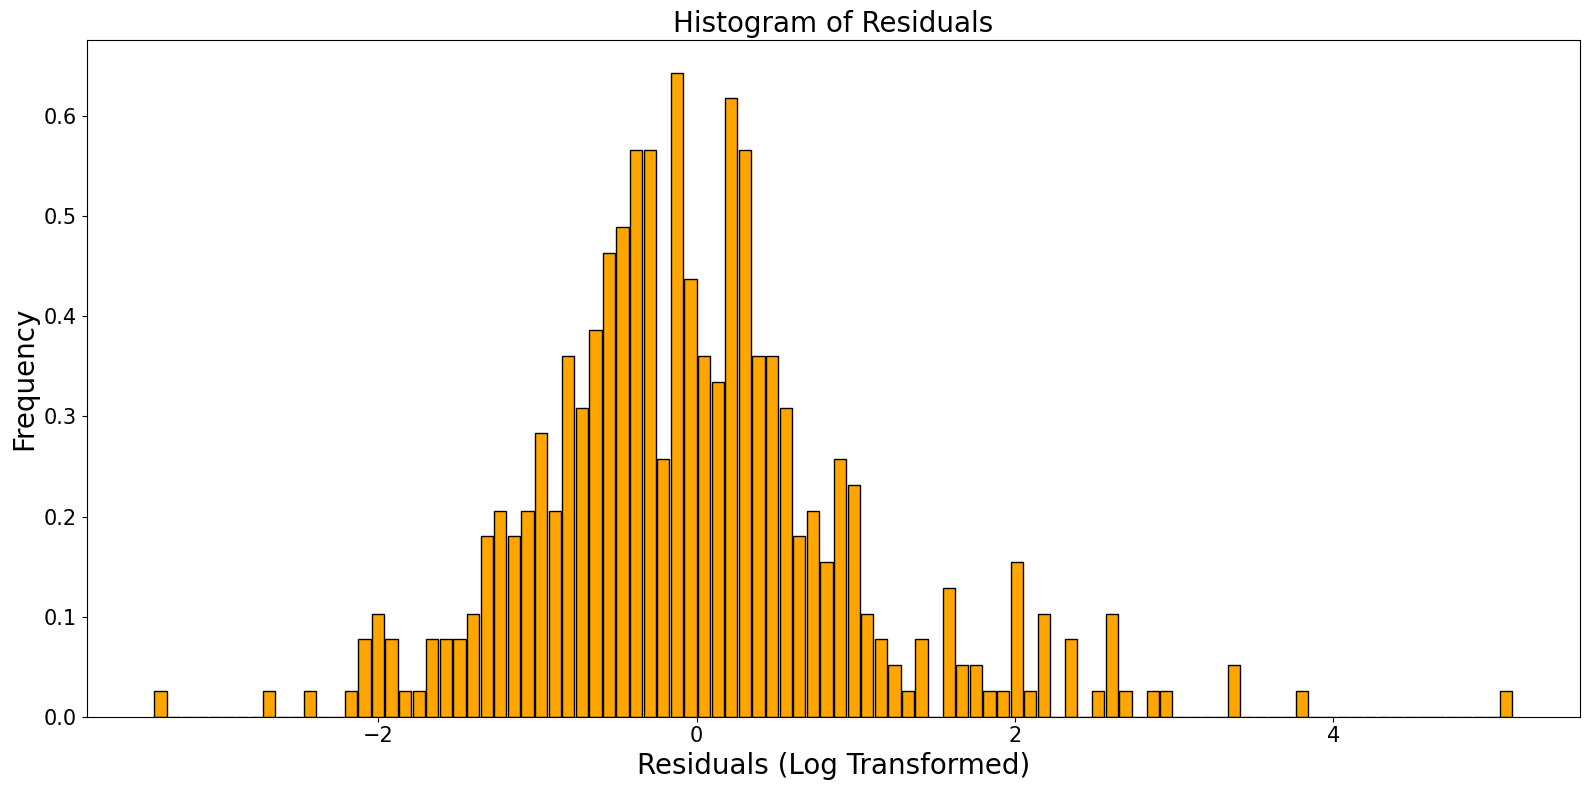

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(y_preds_df['residuals_log'], bins=100, color="orange", rwidth=0.9, edgecolor='black', density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Residuals (Log Transformed)', fontsize=20)
plt.title('Histogram of Residuals', fontsize=20)
fig.tight_layout()

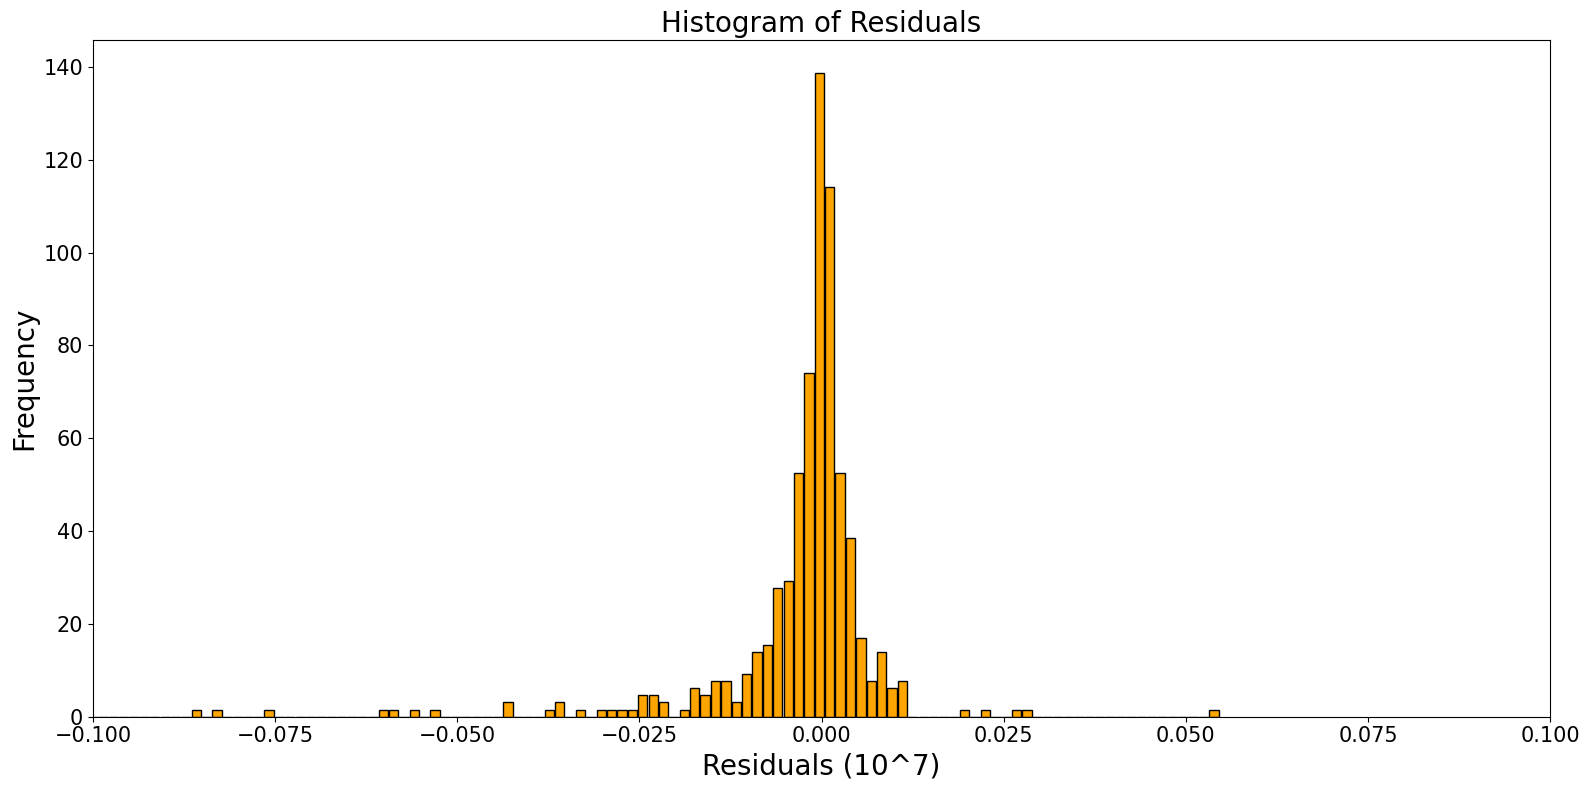

In [35]:
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(y_preds_df['residuals']/10**7, bins=1000, color="orange", rwidth=0.9, edgecolor='black', density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.xlim(-0.1, 0.1)
plt.xlabel('Residuals (10^7)', fontsize=20)
plt.title('Histogram of Residuals', fontsize=20)
fig.tight_layout()

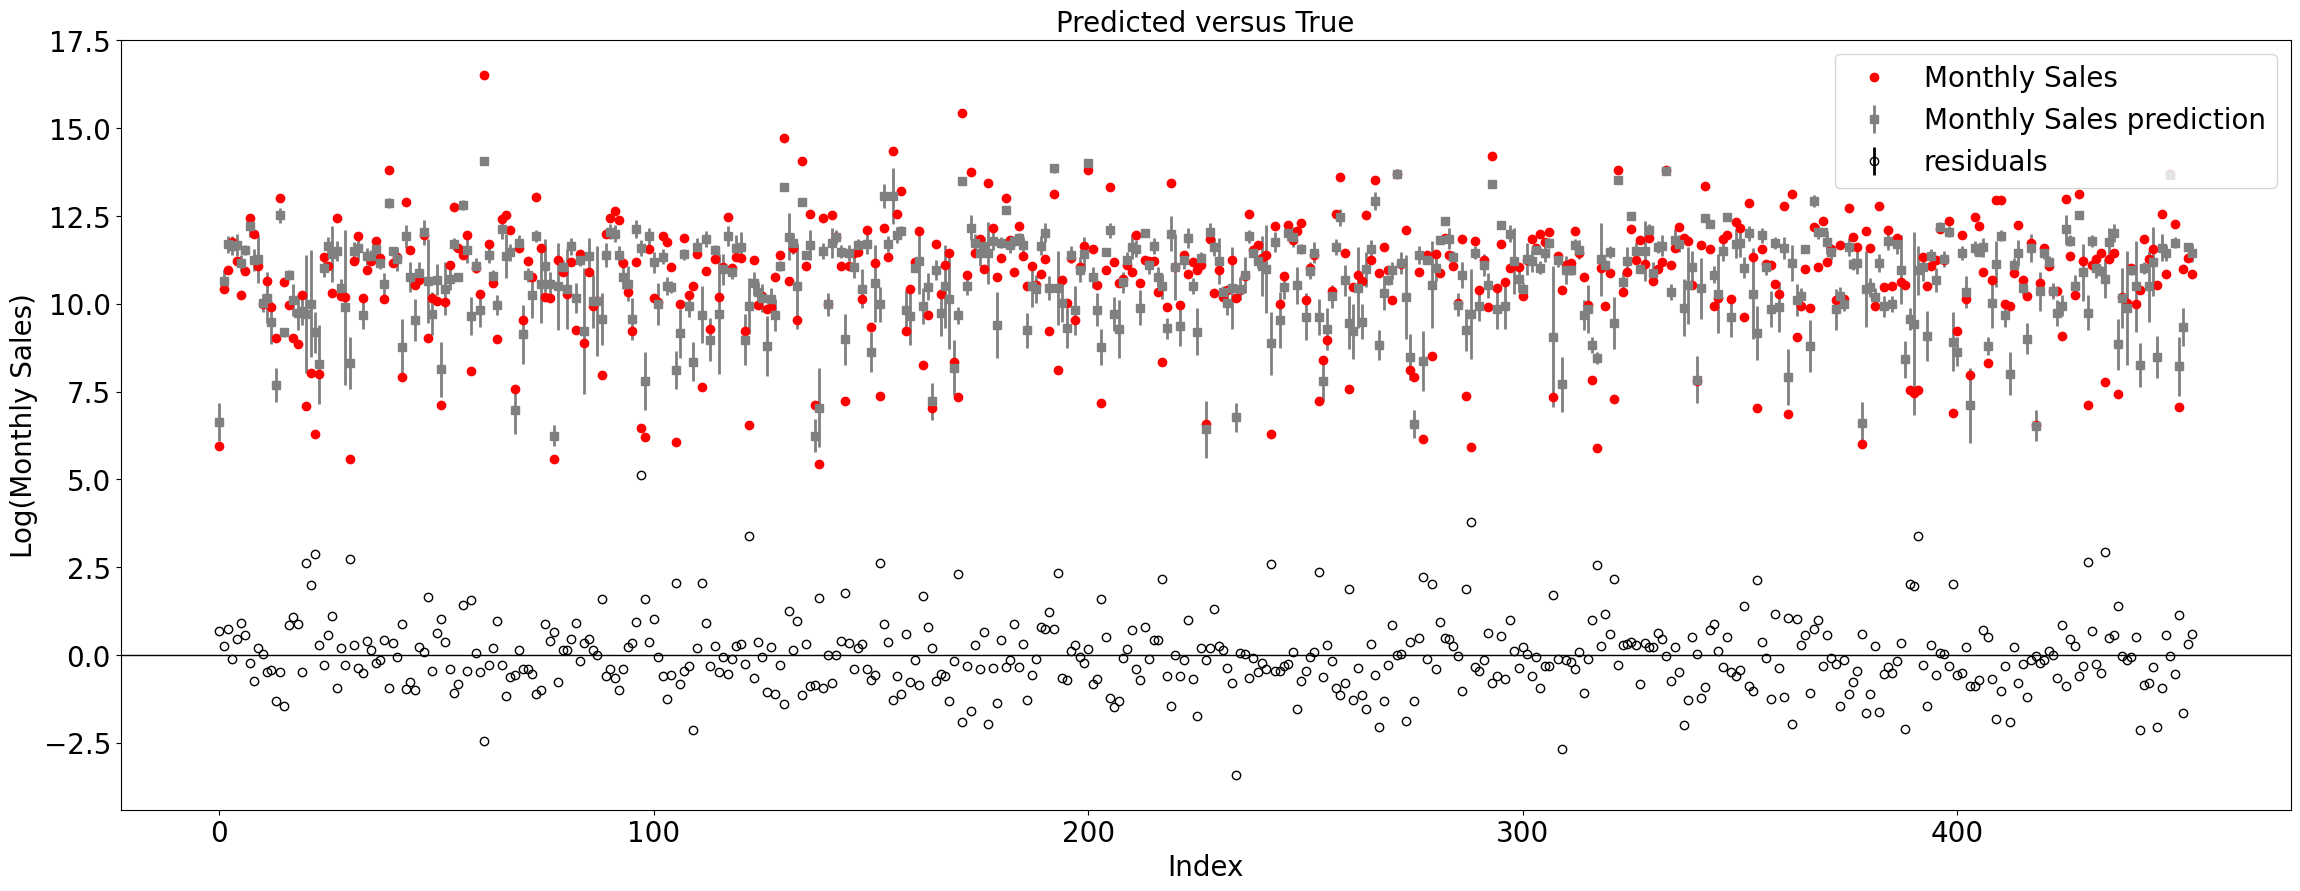

In [36]:
# Predict versus Real plot
monthly_sales = y_preds_df['log_monthly_sales']
monthly_sales_prediction = y_preds_df['log_monthly_sales_prediction']
monthly_sales_error = y_preds_df['total_uncertainty_log']
monthly_sales_residuals = y_preds_df['residuals_log']
monthly_sales_index = y_preds_df.index

fig, ax = plt.subplots(figsize=(28,10))
plt.errorbar(monthly_sales_index, monthly_sales, fmt="ro", lw=3, label="Monthly Sales")
plt.errorbar(monthly_sales_index, monthly_sales_prediction, monthly_sales_error, fmt='s',lw=2,color='gray', label="Monthly Sales prediction")
plt.errorbar(monthly_sales_index, monthly_sales_residuals, 0, fmt='o',lw=2,color='black', fillstyle='none', label="residuals")
plt.axhline(y=0,xmin=0,lw=1,color='black')
plt.xlabel("Index", fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Log(Monthly Sales)", fontsize=20)
plt.title("Predicted versus True", fontsize=20)
plt.xticks(rotation=0, fontsize=20)
plt.legend(fontsize=20)

## Insights

Based on the presented metrics and the provided graphs, some observations and conclusions can be made:

1. **Performance on the Logarithmic Scale**:  
   - The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the logarithmic scale are relatively low, at 0.76 and 1.02, respectively. This suggests that the model performs reasonably well in predicting the order of magnitude of the monthly sales values.  
   - The MAPE (Mean Absolute Percentage Error) on the logarithmic scale is 7.90%, indicating that, on average, the relative errors on the log-transformed scale are acceptable for a regression problem. This suggests the model captures the variations in the data well within the log-transformed space.  

2. **Performance on the Original Scale**:  
   - The MAE and RMSE on the original scale are very high (103,269.43 and 688,719.69, respectively). These values indicate that while the model captures general trends, it exhibits significant discrepancies in absolute predictions.  
   - The MAPE of 168.02% on the original scale is extremely high, showing that the relative errors are substantial when interpreted directly in real values. This suggests poor model performance in representing the data on the original scale.  

3. **Residual Distribution**:  
   - The first histogram shows the distribution of residuals on the logarithmic scale. Its roughly bell-shaped form suggests that the residuals are reasonably well-behaved in this scale, although there are some significant outliers, especially in the tails.  
   - The second histogram, on the original scale, reveals that the residuals are heavily concentrated around zero, but there are significant extreme values. This reinforces the notion that the errors are highly unbalanced when viewed in their original scale.  

4. **Predicted vs. Actual Plot**:  
   - The scatterplot of predictions versus actual values shows that, while the model captures the general trend, there is significant dispersion around the true values, especially for points with extreme values (as highlighted by the residuals in the bottom graph). This indicates that the model fails to capture the extremes of the distribution accurately.  

### Conclusions:  
- The model seems to perform well in predicting orders of magnitude (due to the logarithmic transformation), but it performs poorly on the original scale, which could be problematic if the main objective is achieving absolute precision in predictions.  
- The high MAPE on the original scale suggests that the model may require further refinement, such as incorporating additional explanatory variables. For instance, categorical features like company size and CNAE could provide valuable insights and enhance the model's ability to predict monthly sales more accurately.  

If the primary goal is to predict absolute values, the model needs improvement. However, if the priority is identifying general trends or proportions, the performance on the logarithmic scale may be considered sufficient.  